<a href="https://colab.research.google.com/github/Rohanrathod7/Kaggle_Notebooks/blob/main/Predicting_Student_Score_Challange/Predicting_Student_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction  
This notebook provides a clear and simple workflow for the **“Predicting Student Test Scores” — Kaggle Playground Series** competition.  
We will go through the full process: **loading the data, exploring it, preprocessing, training models, evaluating them, and creating a valid submission file**.

---

## What is Student Test Score Prediction?  
Student test score prediction means predicting the **numerical score** a student will achieve on an exam.  
This is a **regression problem**.

The result depends on factors such as:

- Student's age, study hours, class attendance, sleep hours
- Internet access, sleep quality, study method
- Facility rating, exam difficulty
- Other academic and environmental indicators  

---

## Competition Objective  
Your goal is to **predict the `exam_score` column** for each entry in the test set.

### ✔ Evaluation Metric  
The competition uses **Root Mean Squared Error (RMSE)**, which measures the average magnitude of the errors between predicted and actual values.

---

## About the Dataset  
- The dataset contains **synthetic student records** created for practice.  
- It includes both **numerical** and **categorical** features.  
- The train, test, and sample submission files are located in your Drive:

In [2]:

# ====================================================
# Setup & Imports
# ====================================================

import os
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Settings for cleaner output and consistent plotting
warnings.filterwarnings("ignore") # Suppress warnings for cleaner output
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8) # Default figure size for plots

# Reproducibility
SEED = 42
N_SPLITS = 7
TARGET = 'loan_paid_back'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# # 2. Define the file paths, assuming they are in a subfolder like 'Colab Notebooks' within My Drive
# train_path = '/content/drive/MyDrive/Kaggle/Diebieties prediction challange/train.csv'
# test_path = '/content/drive/MyDrive/Predicting Loan Payback/playground-series-s5e11/test.csv'


import pandas as pd
import numpy as np

# --- 1. Load datasets ---
print("Loading datasets...")
train_path = '/content/drive/MyDrive/Kaggle/Predicting Student Test Scores/train.csv'
test_path = '/content/drive/MyDrive/Kaggle/Predicting Student Test Scores/test.csv'
orig_path = '/content/drive/MyDrive/Kaggle/Predicting Student Test Scores/Exam_Score_Prediction.csv'
sample_submission_path = '/content/drive/MyDrive/Kaggle/Predicting Student Test Scores/sample_submission.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_orig = pd.read_csv(orig_path)
df_sample_submission = pd.read_csv(sample_submission_path)
print("Datasets loaded successfully.")

# --- 2. Print the shape of each dataset ---
print("\n--- Dataset Shapes ---")
print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_test: {df_test.shape}")
print(f"Shape of df_orig: {df_orig.shape}")
print(f"Shape of df_sample_submission: {df_sample_submission.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading datasets...
Datasets loaded successfully.

--- Dataset Shapes ---
Shape of df_train: (630000, 13)
Shape of df_test: (270000, 12)
Shape of df_orig: (20000, 13)
Shape of df_sample_submission: (270000, 2)


In [4]:
def data_info(df, df_name):
    """Comprehensive overview of a DataFrame with styled output."""

    print(f"\n{'='*80}")
    print(f"📊 Comprehensive Information for DataFrame: {df_name}")
    print(f"{'='*80}\n")

    # --- Shape ---
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

    # --- Head ---
    print(f"--- {df_name} Head ---\n")
    display(df.head().style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    # --- Column Summary ---
    print(f"\n--- {df_name} Column Summary ---\n")
    summary = pd.DataFrame({
        "DataType": df.dtypes,
        "Non-Null Count": df.notnull().sum(),
        "Unique Values": df.nunique(),
        "Missing Values": df.isnull().sum(),
        "Missing %": (df.isnull().sum() / len(df)) * 100
    })
    display(summary.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    # --- Describe (numeric only) ---
    if df.select_dtypes(include=np.number).shape[1] > 0:
        print(f"\n--- {df_name} Numeric Summary ---\n")
        display(df.describe().style.set_table_styles([
            {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
            {'selector': 'td', 'props': [('font-size', '10pt')]}
        ], overwrite=False))

    # --- Describe (categorical only) ---
    cat_cols = df.select_dtypes(exclude=np.number).columns
    if len(cat_cols) > 0:
        print(f"\n--- {df_name} Categorical Summary ---\n")
        cat_summary = df[cat_cols].describe().transpose()
        display(cat_summary.style.set_table_styles([
            {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
            {'selector': 'td', 'props': [('font-size', '10pt')]}
        ], overwrite=False))

    print(f"\n{'='*80}\n")

# Apply
data_info(df_train, "df_train")
data_info(df_test, "df_test")
data_info(df_orig, "df_orig")


📊 Comprehensive Information for DataFrame: df_train

Shape: 630000 rows × 13 columns

--- df_train Head ---



,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.910000,98.800000,no,4.900000,average,online videos,low,easy,78.300000
1,1,18,other,diploma,4.950000,94.800000,yes,4.700000,poor,self-study,medium,moderate,46.700000
2,2,20,female,b.sc,4.680000,92.600000,yes,5.800000,poor,coaching,high,moderate,99.000000
3,3,19,male,b.sc,2.000000,49.500000,yes,8.300000,average,group study,high,moderate,63.900000
4,4,23,male,bca,7.650000,86.900000,yes,9.600000,good,self-study,high,easy,100.000000



--- df_train Column Summary ---



,DataType,Non-Null Count,Unique Values,Missing Values,Missing %
id,int64,630000,630000,0,0.000000
age,int64,630000,8,0,0.000000
gender,object,630000,3,0,0.000000
course,object,630000,7,0,0.000000
study_hours,float64,630000,792,0,0.000000
class_attendance,float64,630000,617,0,0.000000
internet_access,object,630000,2,0,0.000000
sleep_hours,float64,630000,66,0,0.000000
sleep_quality,object,630000,3,0,0.000000
study_method,object,630000,5,0,0.000000



--- df_train Numeric Summary ---



,id,age,study_hours,class_attendance,sleep_hours,exam_score
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,20.545821,4.002337,71.987261,7.072758,62.506672
std,181865.479132,2.260238,2.359880,17.430098,1.744811,18.916884
min,0.000000,17.000000,0.080000,40.600000,4.100000,19.599000
25%,157499.750000,19.000000,1.970000,57.000000,5.600000,48.800000
50%,314999.500000,21.000000,4.000000,72.600000,7.100000,62.600000
75%,472499.250000,23.000000,6.050000,87.200000,8.600000,76.300000
max,629999.000000,24.000000,7.910000,99.400000,9.900000,100.000000



--- df_train Categorical Summary ---



,count,unique,top,freq
gender,630000,3,other,211097
course,630000,7,b.tech,131236
internet_access,630000,2,yes,579423
sleep_quality,630000,3,poor,213675
study_method,630000,5,coaching,131697
facility_rating,630000,3,medium,214082
exam_difficulty,630000,3,moderate,353982





📊 Comprehensive Information for DataFrame: df_test

Shape: 270000 rows × 12 columns

--- df_test Head ---



,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.850000,65.200000,yes,5.200000,poor,group study,high,easy
1,630001,18,male,diploma,6.610000,45.000000,no,9.300000,poor,coaching,low,easy
2,630002,24,female,b.tech,6.600000,98.500000,yes,6.200000,good,group study,medium,moderate
3,630003,24,male,diploma,3.030000,66.300000,yes,5.700000,average,mixed,medium,moderate
4,630004,20,female,b.tech,2.030000,42.400000,yes,9.200000,average,coaching,low,moderate



--- df_test Column Summary ---



,DataType,Non-Null Count,Unique Values,Missing Values,Missing %
id,int64,270000,270000,0,0.000000
age,int64,270000,8,0,0.000000
gender,object,270000,3,0,0.000000
course,object,270000,7,0,0.000000
study_hours,float64,270000,786,0,0.000000
class_attendance,float64,270000,604,0,0.000000
internet_access,object,270000,2,0,0.000000
sleep_hours,float64,270000,64,0,0.000000
sleep_quality,object,270000,3,0,0.000000
study_method,object,270000,5,0,0.000000



--- df_test Numeric Summary ---



,id,age,study_hours,class_attendance,sleep_hours
count,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000
mean,764999.500000,20.544137,4.003878,71.982509,7.072070
std,77942.430678,2.260452,2.357741,17.414695,1.745513
min,630000.000000,17.000000,0.080000,40.600000,4.100000
25%,697499.750000,19.000000,1.980000,57.000000,5.600000
50%,764999.500000,21.000000,4.010000,72.600000,7.100000
75%,832499.250000,23.000000,6.050000,87.200000,8.600000
max,899999.000000,24.000000,7.910000,99.400000,9.900000



--- df_test Categorical Summary ---



,count,unique,top,freq
gender,270000,3,male,90682
course,270000,7,b.tech,56461
internet_access,270000,2,yes,248671
sleep_quality,270000,3,good,91754
study_method,270000,5,coaching,56698
facility_rating,270000,3,medium,91816
exam_difficulty,270000,3,moderate,151656





📊 Comprehensive Information for DataFrame: df_orig

Shape: 20000 rows × 13 columns

--- df_orig Head ---



,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.780000,92.900000,yes,7.400000,poor,coaching,low,hard,58.900000
1,2,23,other,bca,3.370000,64.800000,yes,4.600000,average,online videos,medium,moderate,54.800000
2,3,22,male,b.sc,7.880000,76.800000,yes,8.500000,poor,coaching,high,moderate,90.300000
3,4,20,other,diploma,0.670000,48.400000,yes,5.800000,average,online videos,low,moderate,29.700000
4,5,20,female,diploma,0.890000,71.600000,yes,9.800000,poor,coaching,low,moderate,43.700000



--- df_orig Column Summary ---



,DataType,Non-Null Count,Unique Values,Missing Values,Missing %
student_id,int64,20000,20000,0,0.000000
age,int64,20000,8,0,0.000000
gender,object,20000,3,0,0.000000
course,object,20000,7,0,0.000000
study_hours,float64,20000,784,0,0.000000
class_attendance,float64,20000,589,0,0.000000
internet_access,object,20000,2,0,0.000000
sleep_hours,float64,20000,59,0,0.000000
sleep_quality,object,20000,3,0,0.000000
study_method,object,20000,5,0,0.000000



--- df_orig Numeric Summary ---



,student_id,age,study_hours,class_attendance,sleep_hours,exam_score
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.504600,20.473300,4.007604,70.017365,7.008560,62.513225
std,5773.654959,2.284458,2.308313,17.282262,1.732090,18.908491
min,1.000000,17.000000,0.080000,40.600000,4.100000,19.599000
25%,5000.750000,18.000000,2.000000,55.100000,5.500000,48.800000
50%,10000.500000,20.000000,4.040000,69.900000,7.000000,62.600000
75%,15000.250000,22.000000,6.000000,85.000000,8.500000,76.300000
max,20001.000000,24.000000,7.910000,99.400000,9.900000,100.000000



--- df_orig Categorical Summary ---



,count,unique,top,freq
gender,20000,3,other,6726
course,20000,7,bca,2902
internet_access,20000,2,yes,16988
sleep_quality,20000,3,average,6694
study_method,20000,5,self-study,4079
facility_rating,20000,3,medium,6760
exam_difficulty,20000,3,moderate,9878


In [5]:
# Define excluded features: 'id' and the target variable 'loan_paid_back'
excluded_features = ['id', 'loan_paid_back']

print("\n--- Feature Classification Based on df_train ---")

# Separate numerical features from df_train, excluding the specified features
numerical_features = [
    col for col in df_train.select_dtypes(include=np.number).columns
    if col not in excluded_features
]

# Separate categorical features from df_train, excluding the specified features
categorical_features = [
    col for col in df_train.select_dtypes(exclude=np.number).columns
    if col not in excluded_features
]


print("Numerical Features:")
print(f"  Total Count: {len(numerical_features)}")
print(f"  List: {numerical_features}\n")

print("Categorical Features:")
print(f"  Total Count: {len(categorical_features)}")
print(f"  List: {categorical_features}\n")

print("Excluded Features (ID and Target Variable):")
print(f"  List: {excluded_features}\n")


--- Feature Classification Based on df_train ---
Numerical Features:
  Total Count: 5
  List: ['age', 'study_hours', 'class_attendance', 'sleep_hours', 'exam_score']

Categorical Features:
  Total Count: 7
  List: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']

Excluded Features (ID and Target Variable):
  List: ['id', 'loan_paid_back']



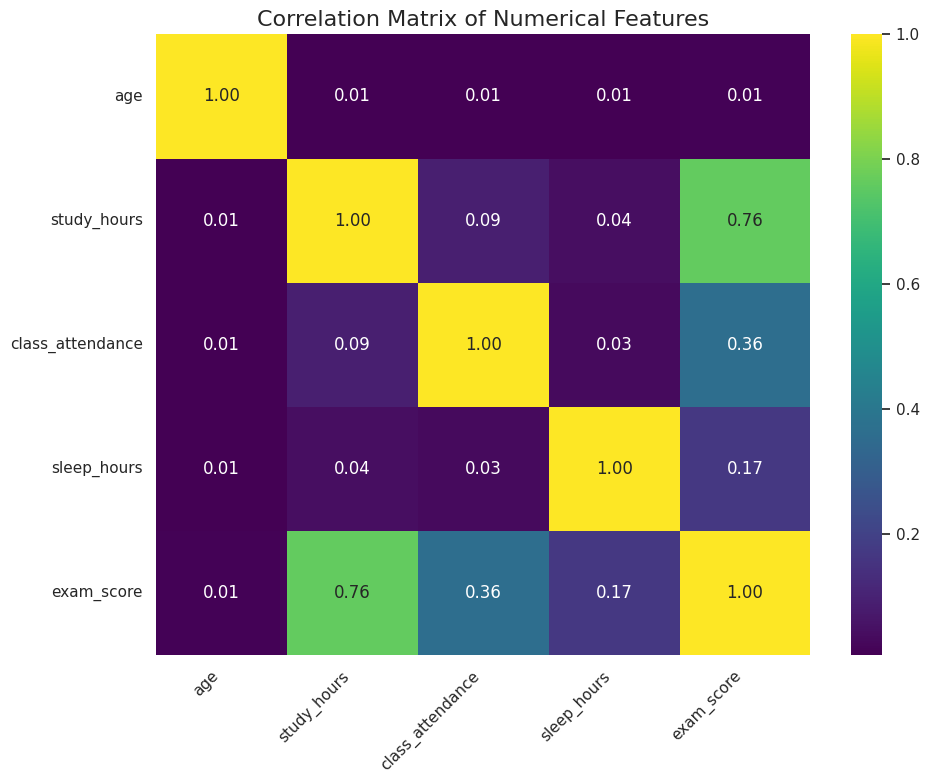

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for numerical features
correlation_matrix = df_train[numerical_features].corr()

# Create a heatmap
plt.figure(figsize=(10, 8)) # Adjust figure size for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



📌 age Summary Statistics:


,Train,Test
Mean,20.545821,20.544137
Median,21.000000,21.000000
Std,2.260238,2.260452


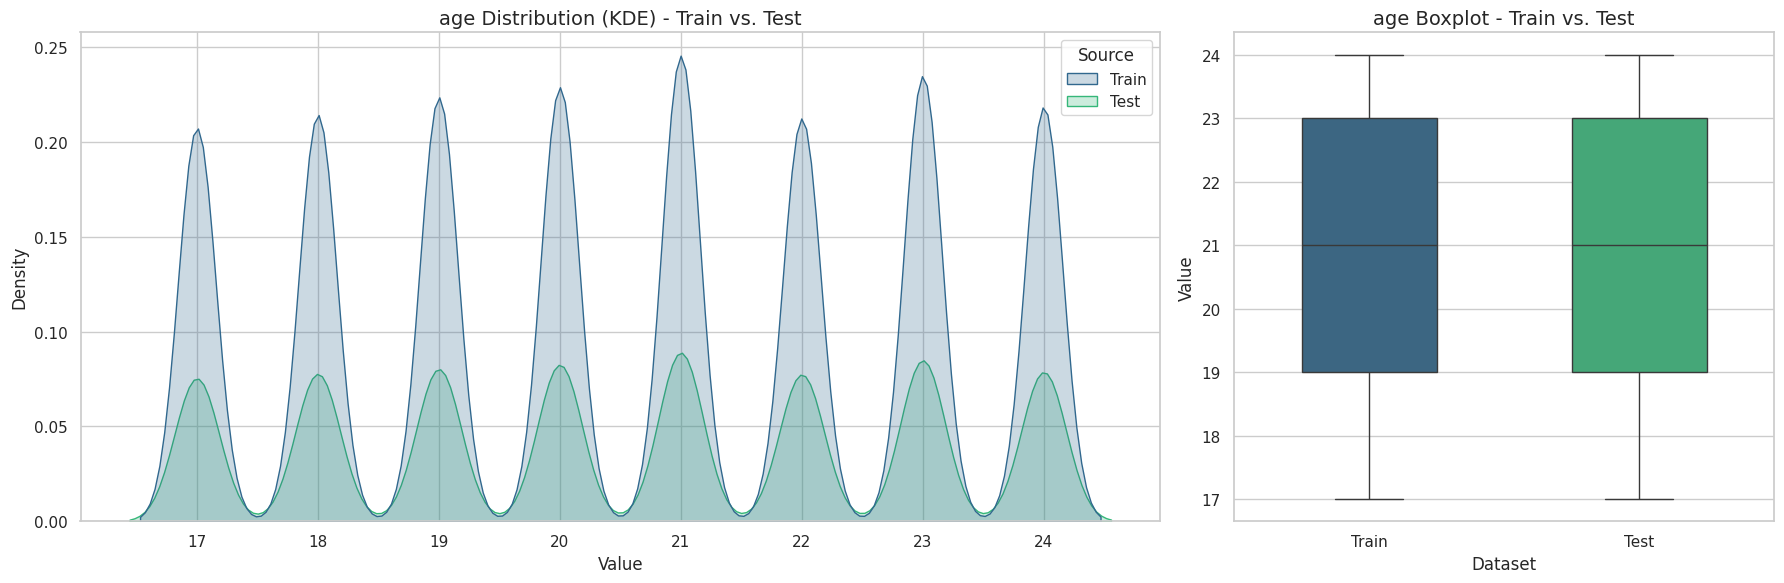


📌 study_hours Summary Statistics:


,Train,Test
Mean,4.002337,4.003878
Median,4.000000,4.010000
Std,2.359880,2.357741


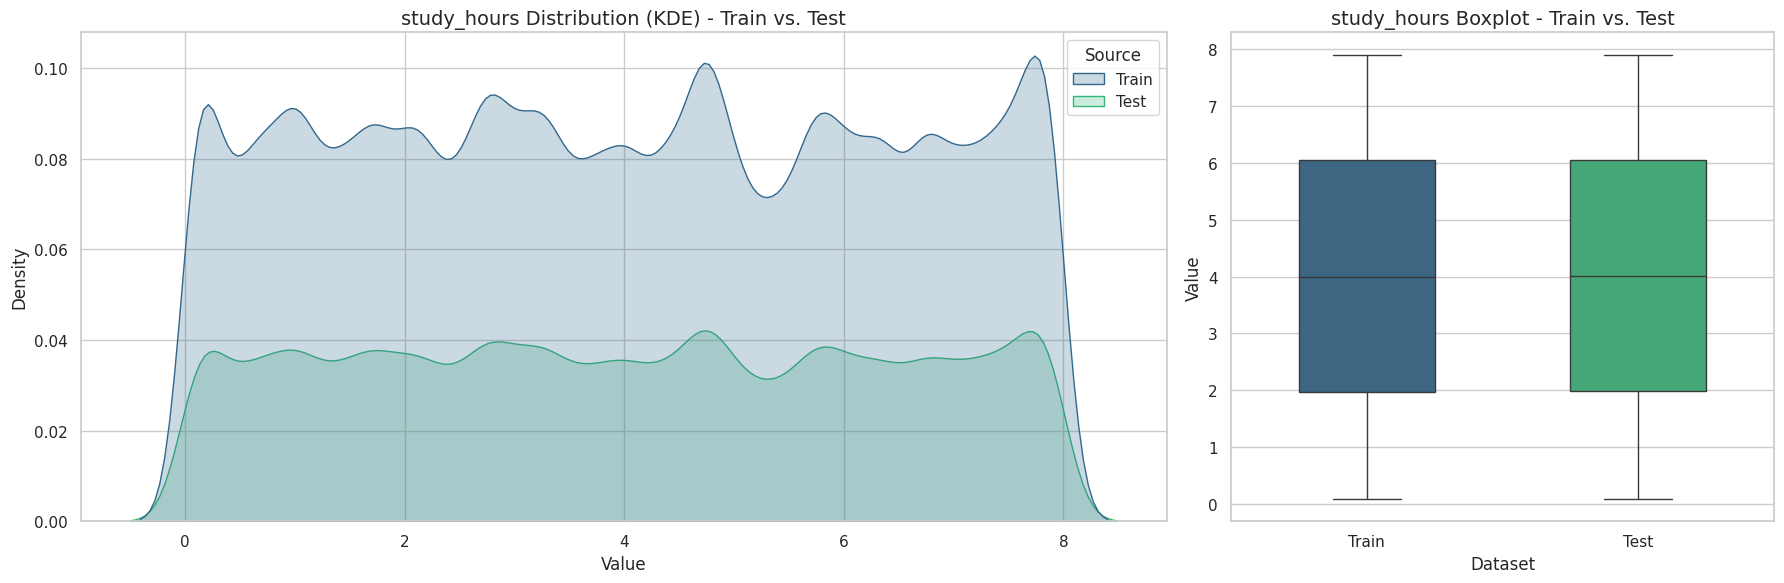


📌 class_attendance Summary Statistics:


,Train,Test
Mean,71.987261,71.982509
Median,72.600000,72.600000
Std,17.430098,17.414695


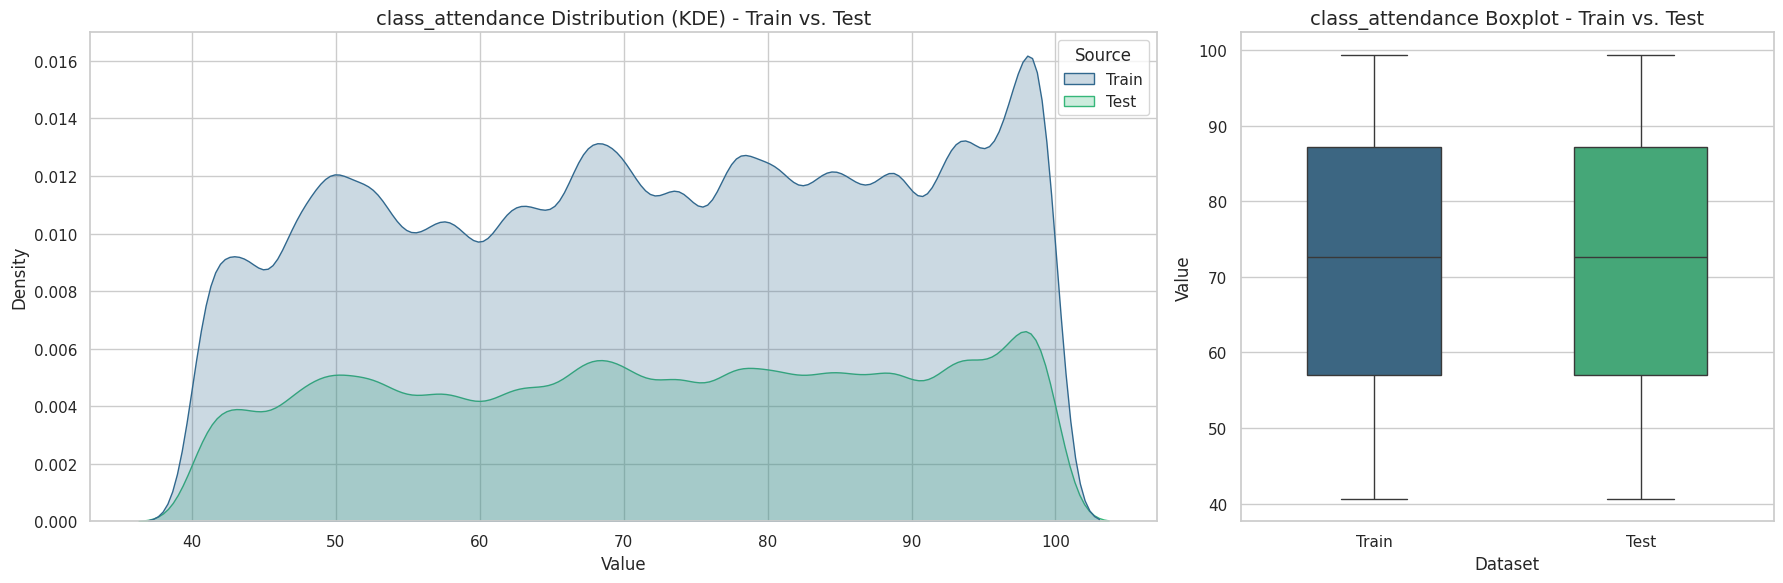


📌 sleep_hours Summary Statistics:


,Train,Test
Mean,7.072758,7.072070
Median,7.100000,7.100000
Std,1.744811,1.745513


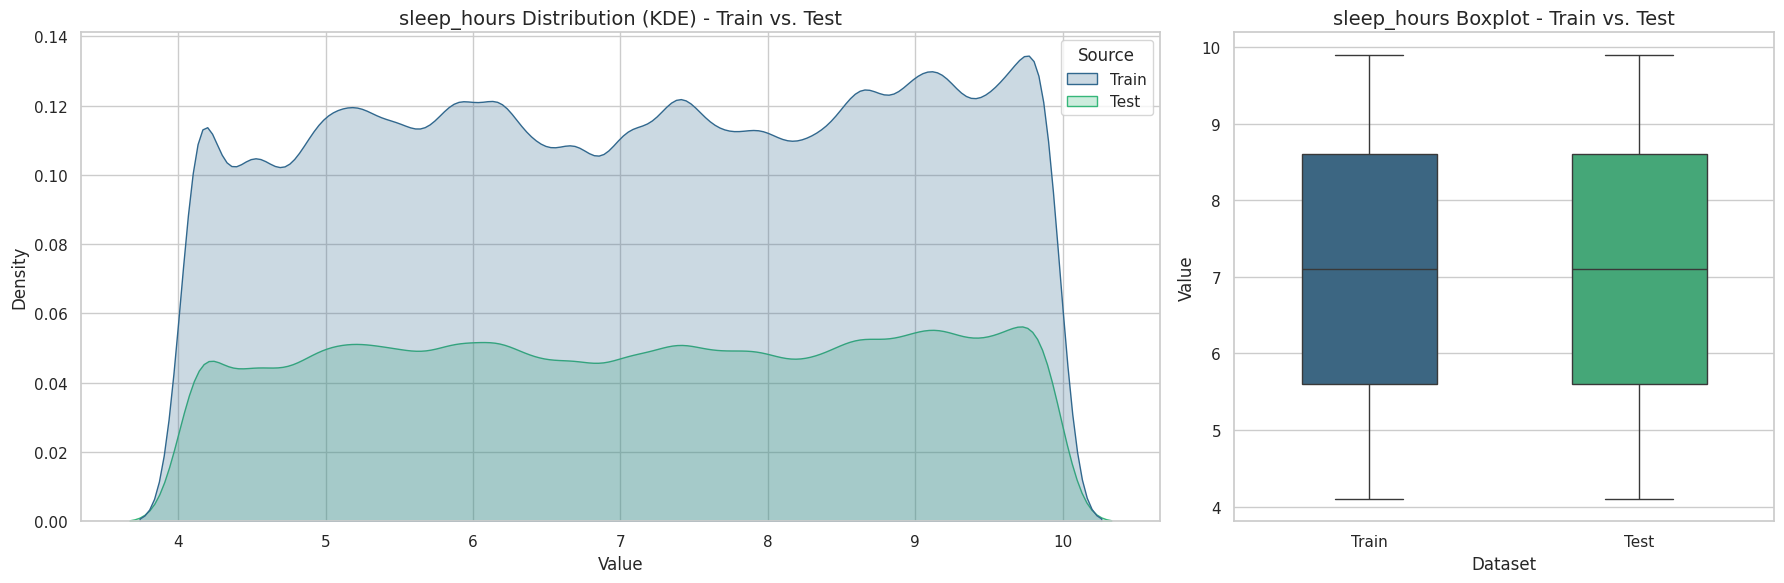


📌 exam_score Summary Statistics:


,Train
Mean,62.506672
Median,62.600000
Std,18.916884


  'exam_score' not found in test_df. Plotting train_df distribution only.


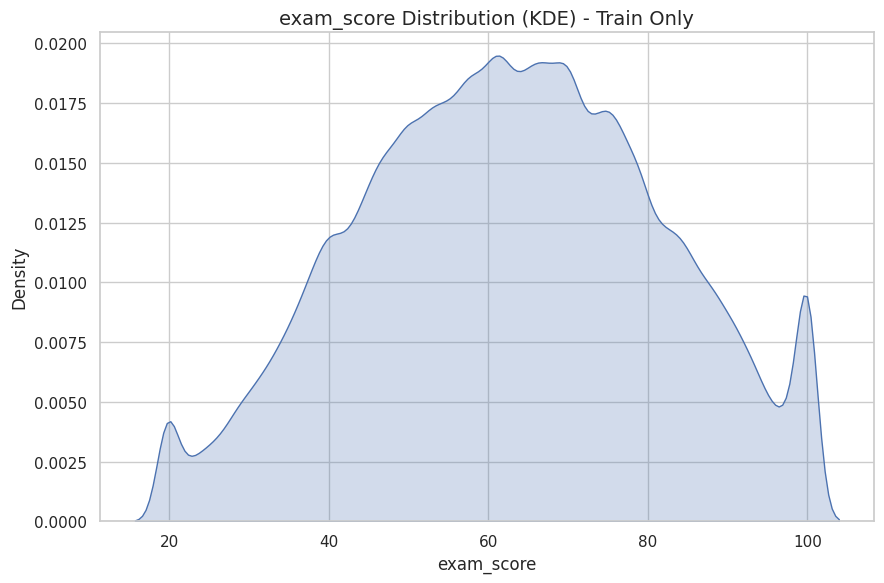

In [7]:
def plot_numerical_distributions(train_df, test_df, numerical_cols):
    """
    Generates KDE and box plots for numerical features, comparing train vs test distributions,
    with summary statistics printed.
    """
    sns.set_style("whitegrid")
    sns.set_context("notebook")

    for col in numerical_cols:
        # Determine which dataframes have the current column
        has_train_col = col in train_df.columns
        has_test_col = col in test_df.columns

        if not has_train_col:
            print(f"Warning: '{col}' not found in train_df. Skipping this column.")
            continue

        print(f"\n📌 {col} Summary Statistics:")

        # Prepare data for summary statistics
        stats_data = {'Train': [train_df[col].mean(), train_df[col].median(), train_df[col].std()]}
        if has_test_col:
            stats_data['Test'] = [test_df[col].mean(), test_df[col].median(), test_df[col].std()]
        display(pd.DataFrame(stats_data, index=['Mean', 'Median', 'Std']))

        if has_test_col:
            # If feature exists in both, create combined_df for comparative plotting
            combined_plot_df = pd.concat([
                train_df[[col]].assign(Source='Train'),
                test_df[[col]].assign(Source='Test')
            ], axis=0, ignore_index=True)

            fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 1]})

            # KDE Plot (comparative)
            sns.kdeplot(
                data=combined_plot_df, x=col, hue='Source', ax=axes[0], fill=True, palette="viridis"
            )
            axes[0].set_title(f'{col} Distribution (KDE) - Train vs. Test', fontsize=14)
            axes[0].set_xlabel('Value')
            axes[0].set_ylabel('Density')

            # Box Plot (comparative)
            sns.boxplot(
                data=combined_plot_df, y=col, x='Source', ax=axes[1],
                orient='v', width=0.5, linewidth=1, fliersize=3, palette="viridis"
            )
            axes[1].set_title(f'{col} Boxplot - Train vs. Test', fontsize=14)
            axes[1].set_xlabel('Dataset')
            axes[1].set_ylabel('Value')

            plt.tight_layout()
            plt.show()
        else:
            # If feature only in train_df, plot train_df distribution only
            print(f"  '{col}' not found in test_df. Plotting train_df distribution only.")
            plt.figure(figsize=(9, 6)) # Single plot
            sns.kdeplot(data=train_df, x=col, fill=True, palette="viridis")
            plt.title(f'{col} Distribution (KDE) - Train Only', fontsize=14)
            plt.xlabel(col) # Label x-axis with column name
            plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

# Call numerical distribution function
plot_numerical_distributions(df_train, df_test, numerical_features)

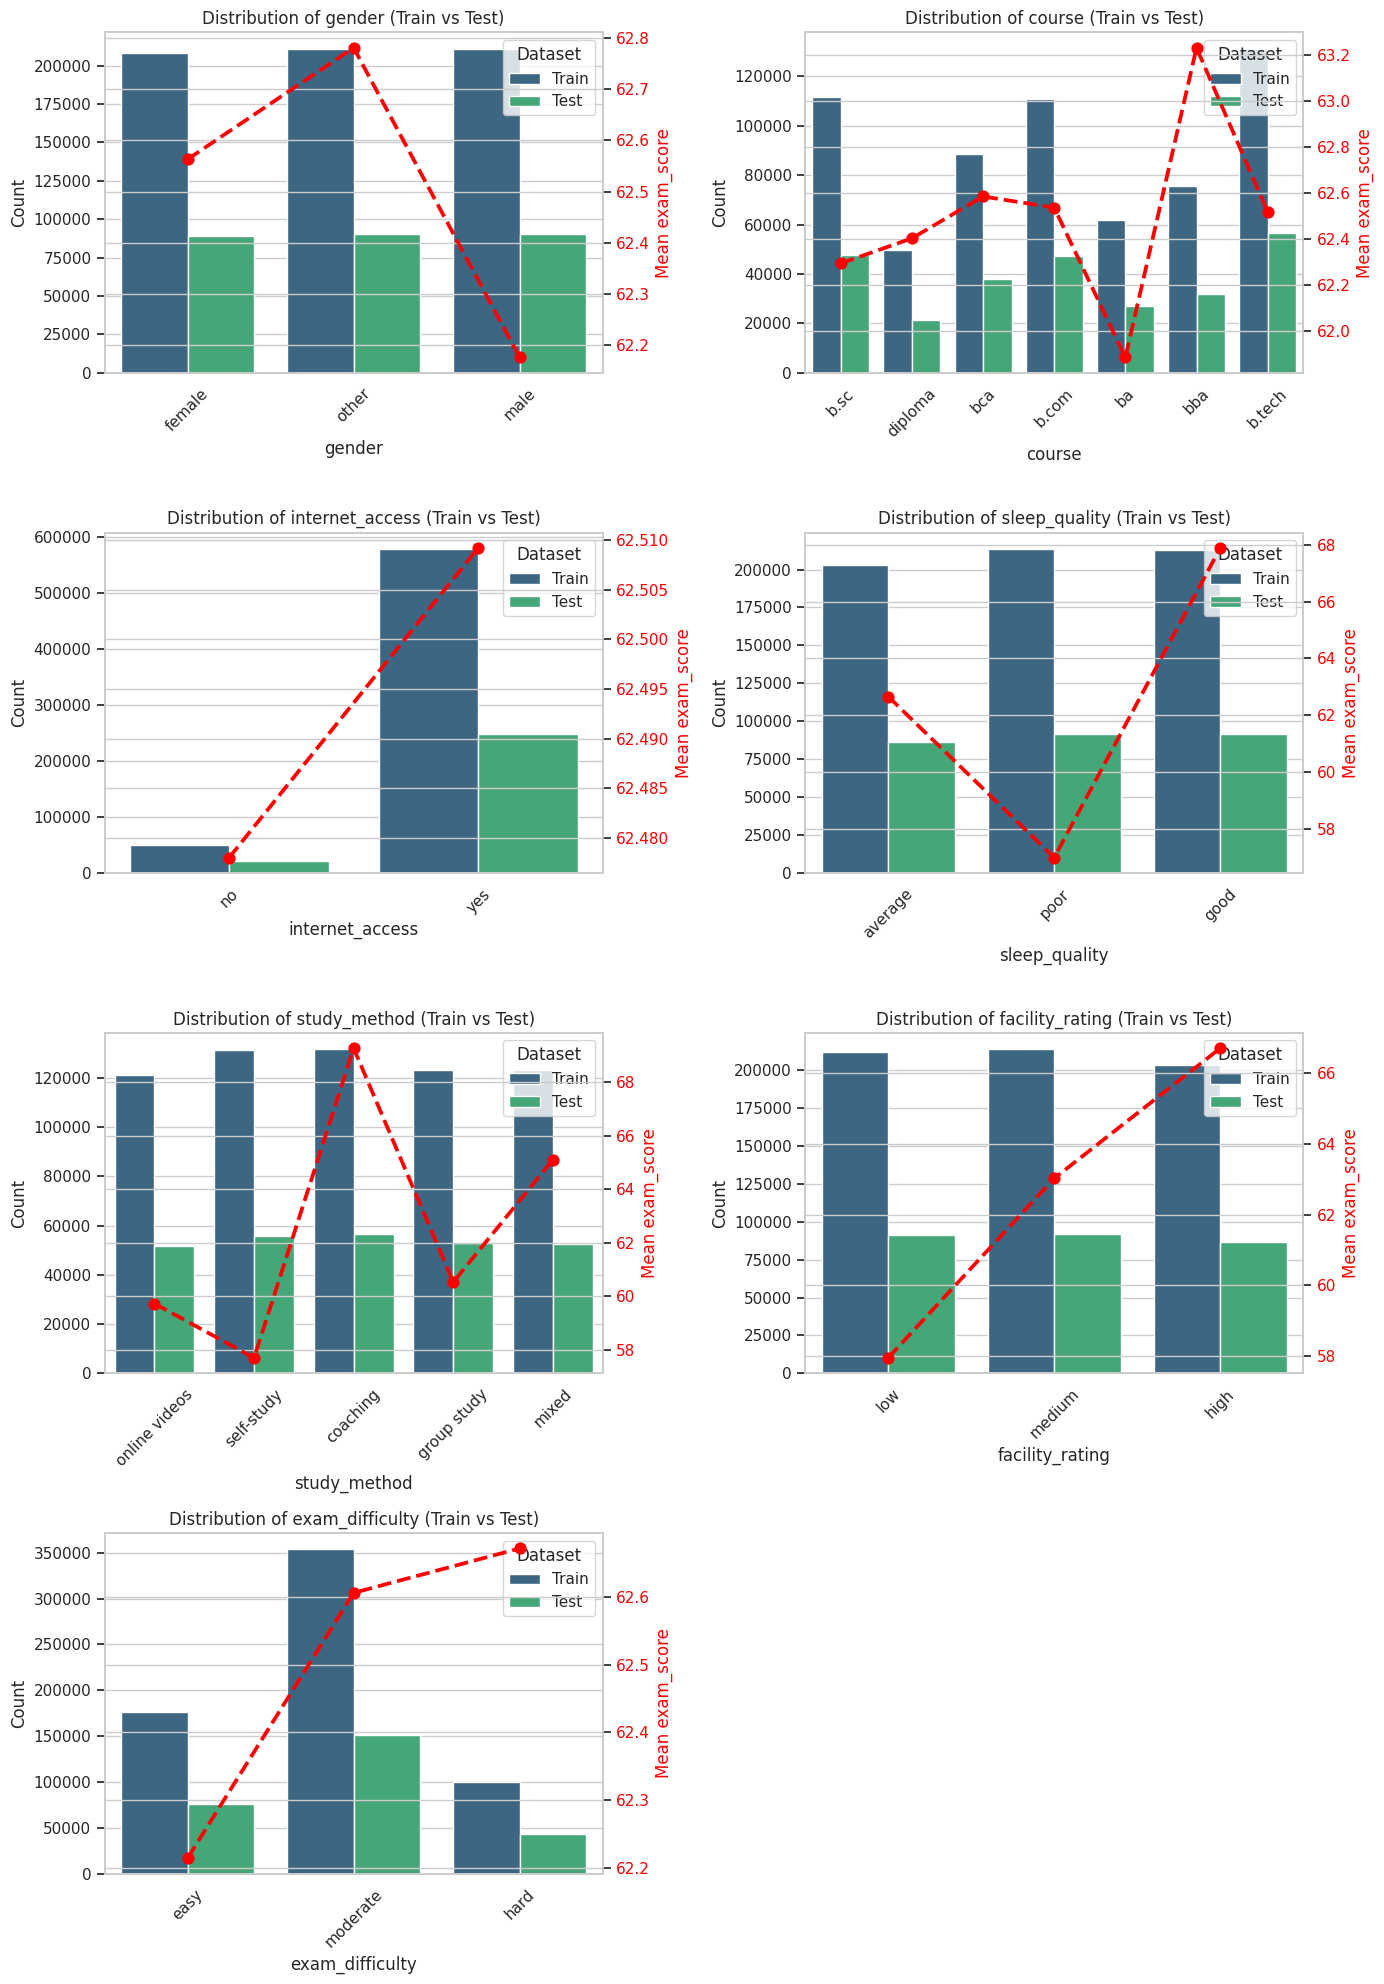

In [8]:
def plot_categorical_distributions(train_df, test_df, categorical_cols, target='exam_score'):
    """
    Generates count plots for each categorical feature (train vs test)
    and bar plots showing mean target per category.
    Uses a denser layout with 2 plots per row.
    """
    if len(categorical_cols) == 0:
        print("No categorical features to plot.")
        return

    palette = ['#1f77b4', '#ff7f0e']  # Train / Test colors
    n_cols = 2
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
    axes = axes.flatten()  # Flatten axes array for easy iteration

    for i, col in enumerate(categorical_cols):
        ax = axes[i]
        # Combine train and test for countplots
        combined = pd.concat([
            train_df[[col]].assign(Source='Train'),
            test_df[[col]].assign(Source='Test')
        ], axis=0, ignore_index=True)

        sns.countplot(x=col, hue='Source', data=combined, palette="viridis", ax=ax)
        ax.set_title(f'Distribution of {col} (Train vs Test)', fontsize=12)
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.legend(title='Dataset')
        ax.tick_params(axis='x', rotation=45)

        # Overlay mean target per category as a line/barplot
        target_means = train_df.groupby(col)[target].mean().sort_values(ascending=False)
        ax2 = ax.twinx()
        sns.pointplot(x=target_means.index, y=target_means.values, ax=ax2, color='red', markers='o', linestyles='--')
        ax2.set_ylabel(f'Mean {target}', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the enhanced function
plot_categorical_distributions(df_train, df_test, categorical_features, target='exam_score')

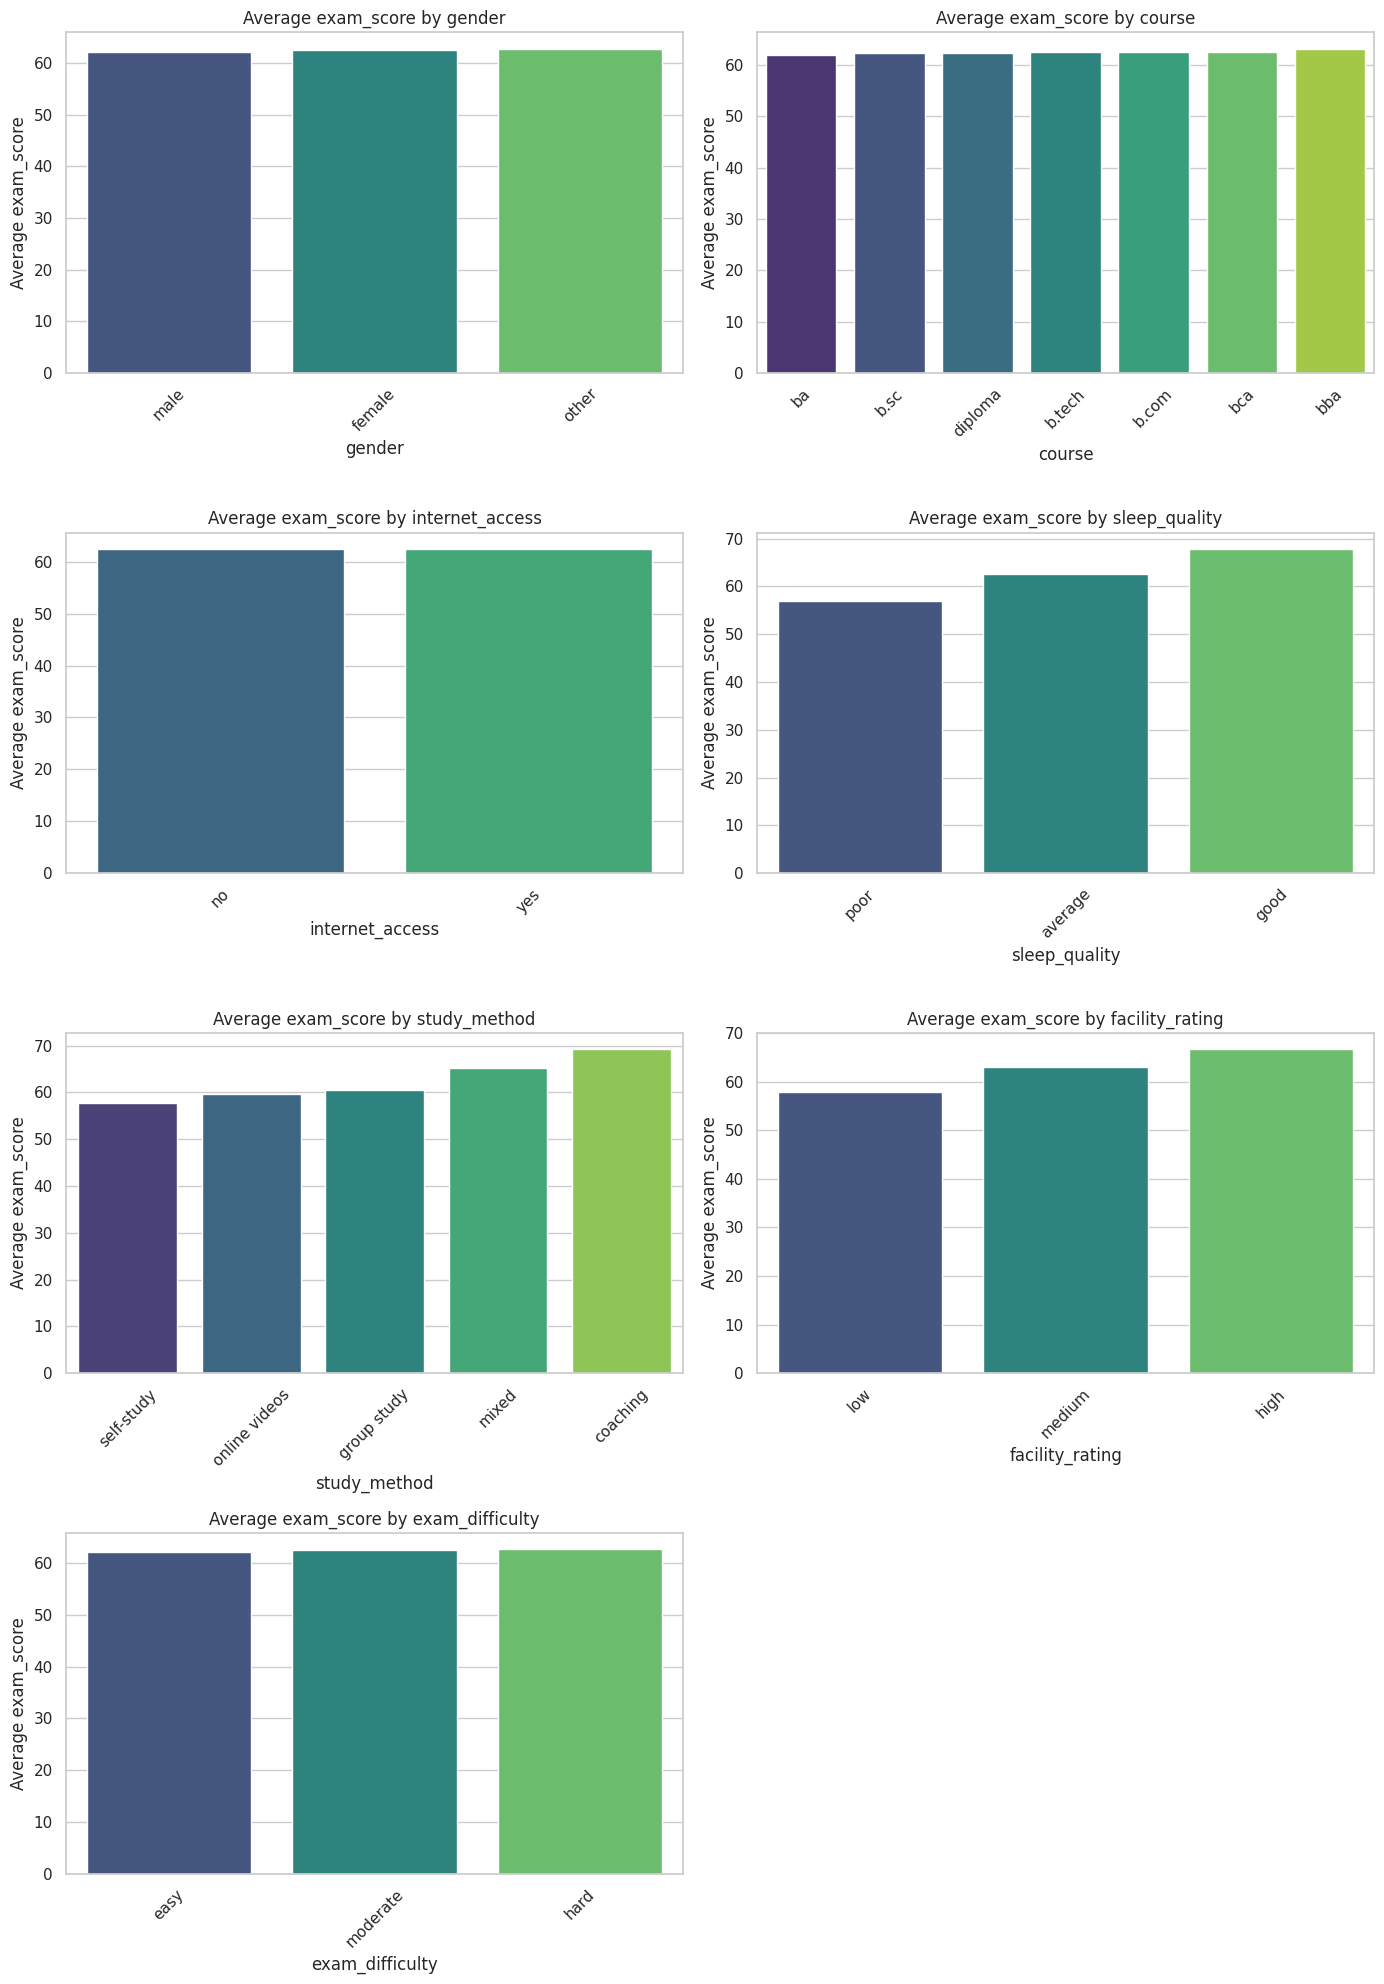

In [9]:
def plot_average_risk_by_category(train_df, categorical_cols, target_col):
    """
    Generates bar plots showing the average target value for each category
    in the specified categorical columns.
    """
    if len(categorical_cols) == 0:
        print("No categorical features to plot.")
        return

    n_cols = 2
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
    axes = axes.flatten() # Flatten the axes array

    for i, col in enumerate(categorical_cols):
        ax = axes[i]
        # Calculate average target value per category
        avg_risk = train_df.groupby(col)[target_col].mean().sort_values()

        sns.barplot(x=avg_risk.index, y=avg_risk.values, ax=ax, palette='viridis')

        ax.set_title(f'Average {target_col} by {col}', fontsize=12)
        ax.set_xlabel(col)
        ax.set_ylabel(f'Average {target_col}')
        ax.tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the function with the corrected target variable
plot_average_risk_by_category(df_train, categorical_features, 'exam_score')

In [10]:

# --- 3. Define variables ---
print("\n--- Defining Feature Sets ---")
TARGET = 'exam_score' # Corrected target column name based on sample_submission

# Ensure TARGET column exists in df_train before proceeding
if TARGET not in df_train.columns:
    print(f"Error: Target column '{TARGET}' not found in df_train. Please verify the target column name.")
else:
    # Use the globally defined original feature lists (from cell e5LwbdT6G0Pk)
    # We redefine BASE, CATS, NUMS here using the original feature lists.
    # This is critical because df_train has already been modified by previous FE steps.
    global BASE, CATS, NUMS
    # Exclude 'exam_score' from numerical_features when constructing BASE and NUMS
    BASE = [col for col in numerical_features if col != TARGET] + categorical_features
    CATS = categorical_features.copy()
    NUMS = [col for col in numerical_features if col != TARGET]

    print(f"Target variable: '{TARGET}'")
    print(f"Total base features (excluding 'id' and target): {len(BASE)} columns")
    print(f"Categorical base features used for engineering: {len(CATS)} columns")
    print(f"Numerical base features: {len(NUMS)} columns")

    # Initialize ALL_FEATS here to ensure it's defined for subsequent steps
    global ALL_FEATS
    ALL_FEATS = BASE.copy() # Start with base features (original features)

    # --- 4. Create orig-based statistical features for both train and test ---
    print("\n--- Creating Orig-based Statistical Features ---")

    # Check if TARGET exists in df_orig before creating orig-based features
    if TARGET not in df_orig.columns:
        print(f"Warning: Target column '{TARGET}' not found in df_orig. Skipping 'orig-based statistical features' creation.")
    else:
        initial_train_cols = df_train.shape[1] # Keep track of current shapes
        initial_test_cols = df_test.shape[1]

        global ORIG_STATS
        ORIG_STATS = [] # Initialize ORIG_STATS globally
        agg_funcs = ['mean', 'std', 'min', 'max', 'median'] # Statistical functions to compute

        # Iterate only over the *original* BASE features that are present in df_orig
        # This prevents trying to create orig_stats for already engineered features
        original_base_features_for_orig_stats = [col for col in BASE if col in df_orig.columns and col != TARGET]

        for col in original_base_features_for_orig_stats:
            # --- Statistical features: mean, std, min, max, median of TARGET grouped by 'col' ---
            # Compute aggregates from df_orig
            stats_df = df_orig.groupby(col)[TARGET].agg(agg_funcs).reset_index()

            # Rename the new columns according to the specified format
            new_stat_col_names = [f'orig_{func}_{col}' for func in agg_funcs]
            stats_df.columns = [col] + new_stat_col_names

            # Merge these features into df_train and df_test using left merge
            # df_train and df_test here are the ALREADY ENGINEERED ones from previous cells.
            df_train = df_train.merge(stats_df, on=col, how='left')
            df_test = df_test.merge(stats_df, on=col, how='left')

            ORIG_STATS.extend(new_stat_col_names)

            # --- Count feature: count of each value in 'col' in df_orig ---
            # Compute value counts from df_orig
            counts_df = df_orig[col].value_counts().reset_index(name=f'orig_count_{col}')
            counts_df.columns = [col, f'orig_count_{col}'] # Ensure correct column names after reset_index

            # Merge this count feature into df_train and df_test using left merge
            df_train = df_train.merge(counts_df, on=col, how='left')
            df_test = df_test.merge(counts_df, on=col, how='left')

            ORIG_STATS.append(f'orig_count_{col}')

        # Add ORIG_STATS to ALL_FEATS
        ALL_FEATS.extend(ORIG_STATS)

        # --- 5. After feature creation ---
        print("\n--- Feature Creation Summary ---")
        print(f"Number of new features added: {len(ORIG_STATS)}")
        print(f"Updated shape of df_train: {df_train.shape}")
        print(f"Updated shape of df_test: {df_test.shape}")


--- Defining Feature Sets ---
Target variable: 'exam_score'
Total base features (excluding 'id' and target): 11 columns
Categorical base features used for engineering: 7 columns
Numerical base features: 4 columns

--- Creating Orig-based Statistical Features ---

--- Feature Creation Summary ---
Number of new features added: 66
Updated shape of df_train: (630000, 79)
Updated shape of df_test: (270000, 78)


In [11]:
def preprocess(df):
    df_temp = df.copy()
    eps = 1e-5

    # Get the original columns from the input dataframe, including 'id' (but retaining 'exam_score' if present)
    original_cols = [col for col in df.columns if col not in []] # Removed 'id' from exclusion list
    # If 'exam_score' is in original df.columns and is the target, ensure it's in original_cols if it needs to be carried through
    # The previous comment indicated retaining 'exam_score', which is now handled by not explicitly excluding it here.

    # ================S
    # BASIC POLYS
    # ================S
    df_temp['study_hours_squared'] = df_temp['study_hours'] ** 2
    df_temp['study_hours_cubed'] = df_temp['study_hours'] ** 3
    df_temp['class_attendance_squared'] = df_temp['class_attendance'] ** 2
    df_temp['sleep_hours_squared'] = df_temp['sleep_hours'] ** 2
    df_temp['age_squared'] = df_temp['age'] ** 2

    # extra polys (tambahan)
    df_temp['study_hours_quartic'] = df_temp['study_hours'] ** 4
    df_temp['class_attendance_cubed'] = df_temp['class_attendance'] ** 3
    df_temp['sleep_hours_cubed'] = df_temp['sleep_hours'] ** 3
    df_temp['age_cubed'] = df_temp['age'] ** 3

    # ================S
    # SAFE LOG/SQRT
    # ================S
    sh_pos = df_temp['study_hours'].clip(lower=0)
    ca_pos = df_temp['class_attendance'].clip(lower=0)
    sl_pos = df_temp['sleep_hours'].clip(lower=0)
    ag_pos = df_temp['age'].clip(lower=0)

    df_temp['log_study_hours'] = np.log1p(sh_pos)
    df_temp['log_class_attendance'] = np.log1p(ca_pos)
    df_temp['log_sleep_hours'] = np.log1p(sl_pos)

    df_temp['sqrt_study_hours'] = np.sqrt(sh_pos)
    df_temp['sqrt_class_attendance'] = np.sqrt(ca_pos)

    # extra transforms
    df_temp['inv_sleep'] = 1.0 / (sl_pos + 1.0)
    df_temp['inv_study'] = 1.0 / (sh_pos + 1.0)
    df_temp['inv_attendance'] = 1.0 / (ca_pos + 1.0)

    # bounded transforms (stabil)
    df_temp['study_tanh'] = np.tanh(df_temp['study_hours'] / 10.0)
    df_temp['sleep_tanh'] = np.tanh(df_temp['sleep_hours'] / 10.0)
    df_temp['attendance_tanh'] = np.tanh(df_temp['class_attendance'] / 100.0)

    df_temp['study_sigmoid'] = 1.0 / (1.0 + np.exp(-(df_temp['study_hours'] - 5.0)))
    df_temp['sleep_sigmoid'] = 1.0 / (1.0 + np.exp(-(df_temp['sleep_hours'] - 7.0)))
    df_temp['attendance_sigmoid'] = 1.0 / (1.0 + np.exp(-(df_temp['class_attendance'] - 85.0) / 8.0))

    # ================S
    # INTERACTIONS (yang kamu punya + tambah)
    # ================S
    df_temp['study_hours_times_attendance'] = df_temp['study_hours'] * df_temp['class_attendance']
    df_temp['study_hours_times_sleep'] = df_temp['study_hours'] * df_temp['sleep_hours']
    df_temp['attendance_times_sleep'] = df_temp['class_attendance'] * df_temp['sleep_hours']

    # interactions tambahan
    df_temp['age_times_study_hours'] = df_temp['age'] * df_temp['study_hours']
    df_temp['age_times_attendance'] = df_temp['age'] * df_temp['class_attendance']
    df_temp['age_times_sleep_hours'] = df_temp['age'] * df_temp['sleep_hours']

    # centered interactions (kadang membantu)
    df_temp['study_center_5'] = df_temp['study_hours'] - 5.0
    df_temp['sleep_center_7'] = df_temp['sleep_hours'] - 7.0
    df_temp['att_center_85'] = df_temp['class_attendance'] - 85.0
    df_temp['study_center_sq'] = df_temp['study_center_5'] ** 2
    df_temp['sleep_center_sq'] = df_temp['sleep_center_7'] ** 2
    df_temp['att_center_sq'] = df_temp['att_center_85'] ** 2

    # ================S
    # RATIOS (yang kamu punya + tambah)
    # ================S
    df_temp['study_hours_over_sleep'] = df_temp['study_hours'] / (df_temp['sleep_hours'] + eps)
    df_temp['attendance_over_sleep'] = df_temp['class_attendance'] / (df_temp['sleep_hours'] + eps)

    # ratios tambahan
    df_temp['attendance_over_study'] = df_temp['class_attendance'] / (df_temp['study_hours'] + eps)
    df_temp['sleep_over_study'] = df_temp['sleep_hours'] / (df_temp['study_hours'] + eps)
    df_temp['study_over_age'] = df_temp['study_hours'] / (df_temp['age'] + eps)
    df_temp['attendance_over_age'] = df_temp['class_attendance'] / (df_temp['age'] + eps)

    # ================S
    # CLIPPED + GAPS
    # ================S
    df_temp['study_hours_clip'] = df_temp['study_hours'].clip(0, 12)
    df_temp['sleep_hours_clip'] = df_temp['sleep_hours'].clip(0, 12)
    df_temp['attendance_clip'] = df_temp['class_attendance'].clip(0, 100)

    df_temp['sleep_gap_8'] = (df_temp['sleep_hours'] - 8.0).abs()
    df_temp['sleep_gap_7'] = (df_temp['sleep_hours'] - 7.0).abs()
    df_temp['attendance_gap_100'] = (df_temp['class_attendance'] - 100.0).abs()
    df_temp['attendance_gap_90'] = (df_temp['class_attendance'] - 90.0).abs()
    df_temp['study_gap_6'] = (df_temp['study_hours'] - 6.0).abs()
    df_temp['study_gap_8'] = (df_temp['study_hours'] - 8.0).abs()

    # ================S
    # BINS (numerik sederhana)
    # ================S
    df_temp["age_bin_num"] = pd.cut(df_temp["age"], bins=[0,17,19,21,23,100], labels=[0,1,2,3,4]).astype(float)
    df_temp["study_bin_num"] = pd.cut(df_temp["study_hours"], bins=[-1,2,4,6,8,100], labels=[0,1,2,3,4]).astype(float)
    df_temp["sleep_bin_num"] = pd.cut(df_temp["sleep_hours"], bins=[-1,5,6,7,8,100], labels=[0,1,2,3,4]).astype(float)
    df_temp["attendance_bin_num"] = pd.cut(df_temp["class_attendance"], bins=[-1,60,75,85,95,101], labels=[0,1,2,3,4]).astype(float)

    # ================S
    # ORDINAL ENCODING (FIX: moderate)
    # ================S
    sleep_quality_map = {'poor': 0, 'average': 1, 'good': 2}
    facility_rating_map = {'low': 0, 'medium': 1, 'high': 2}
    exam_difficulty_map = {'easy': 0, 'moderate': 1, 'hard': 2}

    df_temp['sleep_quality_numeric'] = df_temp['sleep_quality'].map(sleep_quality_map).fillna(1).astype(int)
    df_temp['facility_rating_numeric'] = df_temp['facility_rating'].map(facility_rating_map).fillna(1).astype(int)
    df_temp['exam_difficulty_numeric'] = df_temp['exam_difficulty'].map(exam_difficulty_map).fillna(1).astype(int)

    # interaksi ordinal dengan numerik
    df_temp['study_hours_times_sleep_quality'] = df_temp['study_hours'] * df_temp['sleep_quality_numeric']
    df_temp['attendance_times_facility'] = df_temp['class_attendance'] * df_temp['facility_rating_numeric']
    df_temp['sleep_hours_times_difficulty'] = df_temp['sleep_hours'] * df_temp['exam_difficulty_numeric']

    # ordinal cross
    df_temp['facility_x_sleepq'] = df_temp['facility_rating_numeric'] * df_temp['sleep_quality_numeric']
    df_temp['difficulty_x_facility'] = df_temp['exam_difficulty_numeric'] * df_temp['facility_rating_numeric']
    df_temp['difficulty_x_sleepq'] = df_temp['exam_difficulty_numeric'] * df_temp['sleep_quality_numeric']

    # ================S
    # FLAGS (rule-like)
    # ================S
    df_temp["high_att_low_sleep"] = ((df_temp["class_attendance"] >= 90) & (df_temp["sleep_hours"] <= 6)).astype(int)
    df_temp["high_att_high_study"] = ((df_temp["class_attendance"] >= 90) & (df_temp["study_hours"] >= 6)).astype(int)
    df_temp["low_att_high_study"] = ((df_temp["class_attendance"] <= 60) & (df_temp["study_hours"] >= 7)).astype(int)
    df_temp["ideal_sleep_flag"] = ((df_temp["sleep_hours"] >= 7) & (df_temp["sleep_hours"] <= 9)).astype(int)
    df_temp["short_sleep_flag"] = (df_temp["sleep_hours"] <= 5.5).astype(int)
    df_temp["high_study_flag"] = (df_temp["study_hours"] >= 7).astype(int)

    # ================S
    # COMPOSITE
    # ================S
    df_temp['efficiency'] = (df_temp['study_hours'] * df_temp['class_attendance']) / (df_temp['sleep_hours'] + 1)

    df_temp["efficiency2"] = (
        (df_temp["study_hours_clip"] * df_temp["attendance_clip"]) / (df_temp["sleep_hours_clip"] + 1)
    )

    df_temp["weighted_sum"] = (
        0.06 * df_temp["class_attendance"] +
        2.0  * df_temp["study_hours"] +
        1.2  * df_temp["sleep_hours"]
    )

    df_temp["weighted_sum_x_difficulty"] = df_temp["weighted_sum"] * (1.0 + 0.2 * df_temp["exam_difficulty_numeric"])

    # ------------------------
    # list numeric features
    # ------------------------
    numeric_features = [
        # original + extra polys
        'study_hours_squared', 'study_hours_cubed', 'study_hours_quartic',
        'class_attendance_squared', 'class_attendance_cubed',
        'sleep_hours_squared', 'sleep_hours_cubed',
        'age_squared', 'age_cubed',

        # transforms
        'log_study_hours', 'log_class_attendance', 'log_sleep_hours',
        'sqrt_study_hours', 'sqrt_class_attendance',
        'inv_sleep', 'inv_study', 'inv_attendance',
        'study_tanh', 'sleep_tanh', 'attendance_tanh',
        'study_sigmoid', 'sleep_sigmoid', 'attendance_sigmoid',

        # interactions
        'study_hours_times_attendance', 'study_hours_times_sleep', 'attendance_times_sleep',
        'age_times_study_hours', 'age_times_attendance', 'age_times_sleep_hours',
        'study_center_5', 'sleep_center_7', 'att_center_85',
        'study_center_sq', 'sleep_center_sq', 'att_center_sq',

        # ratios
        'study_hours_over_sleep', 'attendance_over_sleep',
        'attendance_over_study', 'sleep_over_study',
        'study_over_age', 'attendance_over_age',

        # clipped + gaps
        'study_hours_clip', 'sleep_hours_clip', 'attendance_clip',
        'sleep_gap_8', 'sleep_gap_7',
        'attendance_gap_100', 'attendance_gap_90',
        'study_gap_6', 'study_gap_8',

        # bins
        'age_bin_num', 'study_bin_num', 'sleep_bin_num', 'attendance_bin_num',

        # ordinal + interactions
        'sleep_quality_numeric', 'facility_rating_numeric', 'exam_difficulty_numeric',
        'study_hours_times_sleep_quality', 'attendance_times_facility', 'sleep_hours_times_difficulty',
        'facility_x_sleepq', 'difficulty_x_facility', 'difficulty_x_sleepq',

        # flags
        'high_att_low_sleep', 'high_att_high_study', 'low_att_high_study',
        'ideal_sleep_flag', 'short_sleep_flag', 'high_study_flag',

        # composite
        'efficiency', 'efficiency2',
        'weighted_sum', 'weighted_sum_x_difficulty'
    ]

    return df_temp[original_cols + numeric_features], numeric_features

In [12]:
# Apply the preprocess function to df_train and df_test
print("Applying feature engineering to df_train...")
df_train_processed, numeric_engineered_features = preprocess(df_train)
print("Applying feature engineering to df_test...")
df_test_processed, _ = preprocess(df_test)

# Update the global ALL_FEATS list with the newly engineered numeric features
global ALL_FEATS
ALL_FEATS = ALL_FEATS + numeric_engineered_features

print(f"\nFeature engineering applied. New features added: {len(numeric_engineered_features)}")
print(f"Updated shape of df_train_processed: {df_train_processed.shape}")
print(f"Updated shape of df_test_processed: {df_test_processed.shape}")
print(f"Total features in ALL_FEATS: {len(ALL_FEATS)}")

# Assign the processed dataframes back to df_train and df_test for consistency with subsequent steps
df_train = df_train_processed
df_test = df_test_processed

print("DataFrames updated with engineered features.")

Applying feature engineering to df_train...
Applying feature engineering to df_test...

Feature engineering applied. New features added: 73
Updated shape of df_train_processed: (630000, 152)
Updated shape of df_test_processed: (270000, 151)
Total features in ALL_FEATS: 150
DataFrames updated with engineered features.


In [13]:
# =============================================================================
# STEP 2: Categorical Feature Engineering - Count Encoding
# =============================================================================
print("\n[STEP 2] Engineering Categorical Features (Count Encoding)...\n")

# 1. Set the TARGET variable (already defined globally as 'exam_score', but setting locally for clarity)
TARGET = 'exam_score'

# 2. Initialize an empty list named CE to store the names of the newly created count-encoded features
CE = []

# List of categorical features (obtained from previous cells)
# Ensure this list is correct based on prior EDA and feature classification
# categorical_features = ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']
# The global `categorical_features` variable holds the correct list, so we'll use that.

initial_train_cols = df_train.shape[1]
initial_test_cols = df_test.shape[1]

# 3. Iterate through each categorical column and apply count encoding
print(f"Applying Count Encoding for {len(categorical_features)} features...")
for i, col in enumerate(categorical_features):
    print(f"  Processing: {col} ({i+1}/{len(categorical_features)})")

    # a. Calculate the value counts of its categories using df_train only
    # This prevents data leakage from the test set
    if col in df_train.columns:
        counts = df_train[col].value_counts()
    else:
        print(f"Warning: Column '{col}' not found in df_train. Skipping count encoding for this column.")
        continue

    # b. Create a new column name
    new_col_name = f'CE_{col}'

    # c. Apply these calculated counts as new features to both df_train and df_test
    # Use .map() and fill any categories in the test set not present in training set with 0
    df_train[new_col_name] = df_train[col].map(counts).fillna(0)
    df_test[new_col_name] = df_test[col].map(counts).fillna(0)

    # d. Add the name of the new count-encoded feature to the CE list
    CE.append(new_col_name)

# 5. Print a summary
print("\n--- Feature Creation Summary ---")
print(f"Number of new count-encoded features added: {len(CE)}")
print(f"Updated shape of df_train: {df_train.shape}")
print(f"Updated shape of df_test: {df_test.shape}")

print("Count Encoding complete.")



[STEP 2] Engineering Categorical Features (Count Encoding)...

Applying Count Encoding for 7 features...
  Processing: gender (1/7)
  Processing: course (2/7)
  Processing: internet_access (3/7)
  Processing: sleep_quality (4/7)
  Processing: study_method (5/7)
  Processing: facility_rating (6/7)
  Processing: exam_difficulty (7/7)

--- Feature Creation Summary ---
Number of new count-encoded features added: 7
Updated shape of df_train: (630000, 159)
Updated shape of df_test: (270000, 158)
Count Encoding complete.


In [14]:
import itertools
import pandas as pd
import numpy as np

class InteractionFeatureGenerator:
    def __init__(self, base_features, three_way_triplets):
        self.base_features = base_features
        self.three_way_triplets = three_way_triplets

    def _create_interaction_feature(self, df, cols, name):
        """Helper to create a single interaction feature."""
        # Ensure all columns exist in the dataframe before proceeding
        if all(c in df.columns for c in cols):
            df[name] = df[cols[0]].astype(str)
            for col in cols[1:]:
                df[name] += '_' + df[col].astype(str)
            return True
        return False

    def generate(self, train, test, orig):
        created_features = []
        two_way_count = 0
        three_way_count = 0

        # --- Generate 2-way interaction features (bigrams) ---
        for col1, col2 in itertools.combinations(self.base_features, 2):
            feature_name = f"{col1}_{col2}"

            # Apply to train
            if self._create_interaction_feature(train, [col1, col2], feature_name):
                _ = self._create_interaction_feature(test, [col1, col2], feature_name) # Apply to test
                _ = self._create_interaction_feature(orig, [col1, col2], feature_name) # Apply to orig
                created_features.append(feature_name)
                two_way_count += 1

        print(f"Created {two_way_count} 2-way interaction features.")

        # --- Generate 3-way interaction features ---
        for triplet in self.three_way_triplets:
            col1, col2, col3 = triplet
            feature_name = f"{col1}_{col2}_{col3}"

            # Apply to train
            if self._create_interaction_feature(train, [col1, col2, col3], feature_name):
                _ = self._create_interaction_feature(test, [col1, col2, col3], feature_name) # Apply to test
                _ = self._create_interaction_feature(orig, [col1, col2, col3], feature_name) # Apply to orig
                created_features.append(feature_name)
                three_way_count += 1

        print(f"Created {three_way_count} 3-way interaction features.")

        return train, test, orig, created_features


# --- Student-centric Feature Engineering ---

# Define TE_BASE as BASE (all relevant features for interaction generation)
TE_BASE = BASE

# Define triplets for 3-way interaction features based on student-centric concepts
triplets = [
    ('study_hours', 'class_attendance', 'sleep_hours'),
    ('course', 'study_method', 'exam_difficulty'),
    ('gender', 'internet_access', 'sleep_quality')
]

# Initialize the InteractionFeatureGenerator
gen = InteractionFeatureGenerator(TE_BASE, triplets)

# Generate interaction features for df_train, df_test, and df_orig
df_train, df_test, df_orig, inter_feats_local = gen.generate(df_train, df_test, df_orig)

# Make INTER and INTER_3WAY global and populate them
global INTER_3WAY
global INTER

INTER_3WAY = [f"{t[0]}_{t[1]}_{t[2]}" for t in triplets]
INTER = [f for f in inter_feats_local if f not in INTER_3WAY]

print(f"\nTotal interaction features created: {len(inter_feats_local)}")
print("Updated shapes after interaction feature creation:")
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")
print(f"Orig: {df_orig.shape}")

Created 55 2-way interaction features.
Created 3 3-way interaction features.

Total interaction features created: 58
Updated shapes after interaction feature creation:
Train: (630000, 217)
Test: (270000, 216)
Orig: (20000, 71)


In [15]:
# ───────────
# 3) QUANTILE FEATURES
# ───────────
print("\n[3/4] Quantile Features...")
global QFEAT
QFEAT = []

# Identify numerical features from BASE that are suitable for quantile features (excluding target if present)
student_numerical_features = [col for col in BASE if col not in categorical_features and col != TARGET]

for col in student_numerical_features:
    # Ensure the column exists in df_train before proceeding
    if col in df_train.columns:
        # Using df_train to calculate quantiles to avoid data leakage from df_test
        quantiles = np.percentile(df_train[col], np.arange(0, 101, 5))
        qcol = f'{col}_quantile'

        df_train[qcol] = np.digitize(df_train[col], quantiles)
        # Apply to test, handling potential absence of the column (though unlikely for base features)
        if col in df_test.columns:
            df_test[qcol] = np.digitize(df_test[col], quantiles)
        else:
            print(f"Warning: '{col}' not found in df_test for quantile feature creation.")
        # Apply to orig
        if col in df_orig.columns:
            df_orig[qcol] = np.digitize(df_orig[col], quantiles)
        else:
            print(f"Warning: '{col}' not found in df_orig for quantile feature creation.")

        QFEAT.append(qcol)
    else:
        print(f"Warning: '{col}' not found in df_train. Skipping quantile feature creation for this column.")

print(f"✓ Created {len(QFEAT)} quantile features")

# ───────────
# 4) ROUNDING FEATURES
# ───────────
print("\n[4/4] Rounding Features...")
global ROUND
ROUND = []
rounding_levels = {'1s': 0, '10s': -1, '100s': -2}

# Identify numerical features from BASE that are suitable for rounding
# Using the same list as for quantile features for consistency
for col in student_numerical_features:
    # Ensure the column exists in df_train before proceeding
    if col in df_train.columns:
        for suffix, level in rounding_levels.items():
            new_col = f"{col}_ROUND_{suffix}"
            ROUND.append(new_col)

            # Apply to train, test, and orig
            df_train[new_col] = df_train[col].round(level).astype(int)
            if col in df_test.columns:
                df_test[new_col] = df_test[col].round(level).astype(int)
            else:
                print(f"Warning: '{col}' not found in df_test for rounding feature creation.")
            if col in df_orig.columns:
                df_orig[new_col] = df_orig[col].round(level).astype(int)
            else:
                print(f"Warning: '{col}' not found in df_orig for rounding feature creation.")
    else:
        print(f"Warning: '{col}' not found in df_train. Skipping rounding feature creation for this column.")

print(f"✓ Created {len(ROUND)} rounding features")

# ───────────
# FINAL FEATURE LIST
# ───────────
global ALL_FEATS

# ALL_FEATS should already contain BASE, ORIG_STATS, and numeric_engineered_features from previous cells.
# Now, append CE, INTER, INTER_3WAY (if they haven't been added yet) and the features from this cell.

# Append CE features
if 'CE' in globals() and isinstance(CE, list):
    # Only extend if not already added to avoid duplicates if cell is re-run multiple times.
    # A more robust check might be needed for perfect deduplication if feature names are identical.
    ALL_FEATS.extend([f for f in CE if f not in ALL_FEATS])

# Append Interaction features
if 'INTER' in globals() and isinstance(INTER, list):
    ALL_FEATS.extend([f for f in INTER if f not in ALL_FEATS])
if 'INTER_3WAY' in globals() and isinstance(INTER_3WAY, list):
    ALL_FEATS.extend([f for f in INTER_3WAY if f not in ALL_FEATS])

# Append Quantile and Rounding features generated in this cell
ALL_FEATS.extend([f for f in QFEAT if f not in ALL_FEATS])
ALL_FEATS.extend([f for f in ROUND if f not in ALL_FEATS])

print(f"\n✅ Total Features: {len(ALL_FEATS)}")


[3/4] Quantile Features...
✓ Created 4 quantile features

[4/4] Rounding Features...
✓ Created 12 rounding features

✅ Total Features: 231


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

class TargetEncoder:
    def __init__(self, cols_to_encode, aggs=['mean'], cv=5, smooth=1.0, drop_original=False):
        self.cols_to_encode = cols_to_encode
        self.aggs = aggs
        self.cv = cv
        self.smooth = smooth
        self.drop_original = drop_original
        self.mappings_ = {}
        self.global_agg_stats_ = {}
        self.global_mean_for_smoothing_ = None

    def _calculate_global_mean_for_smoothing(self, y):
        return y.mean()

    def _calculate_global_agg_stats(self, y):
        global_agg_stats = {}
        for agg in self.aggs:
            if agg == 'mean':
                global_agg_stats[agg] = y.mean()
            elif agg == 'std':
                global_agg_stats[agg] = y.std()
            elif agg == 'min':
                global_agg_stats[agg] = y.min()
            elif agg == 'max':
                global_agg_stats[agg] = y.max()
            elif agg == 'median':
                global_agg_stats[agg] = y.median()
            # Add other aggregations as needed
        return global_agg_stats

    def _calculate_fold_mapping(self, X_subset, y_subset, col, fold_global_mean_for_smoothing):
        col_mappings = {}
        temp_df = X_subset[[col]].copy()
        temp_df['target'] = y_subset

        for agg in self.aggs:
            if agg == 'mean':
                agg_df = temp_df.groupby(col)['target'].agg(['mean', 'count'])
                smoothed_mean = (agg_df['count'] * agg_df['mean'] + self.smooth * fold_global_mean_for_smoothing) / (agg_df['count'] + self.smooth)
                col_mappings[agg] = smoothed_mean
            else:
                col_mappings[agg] = temp_df.groupby(col)['target'].agg(agg)
        return col_mappings

    def fit(self, X, y):
        self.global_mean_for_smoothing_ = self._calculate_global_mean_for_smoothing(y)
        self.global_agg_stats_ = self._calculate_global_agg_stats(y)

        for col in self.cols_to_encode:
            self.mappings_[col] = {}
            temp_df = X[[col]].copy()
            temp_df['target'] = y

            for agg in self.aggs:
                if agg == 'mean':
                    agg_df = temp_df.groupby(col)['target'].agg(['mean', 'count'])
                    smoothed_mean = (agg_df['count'] * agg_df['mean'] + self.smooth * self.global_mean_for_smoothing_) / (agg_df['count'] + self.smooth)
                    self.mappings_[col][agg] = smoothed_mean
                else:
                    self.mappings_[col][agg] = temp_df.groupby(col)['target'].agg(agg)
        return self

    def transform(self, X):
        X_transformed = X.copy()

        for col in self.cols_to_encode:
            for agg in self.aggs:
                new_col_name = f"TE_{col}_{agg}"
                fill_value = self.global_agg_stats_.get(agg, np.nan)
                X_transformed[new_col_name] = X_transformed[col].map(self.mappings_[col][agg]).fillna(fill_value)

            if self.drop_original:
                X_transformed = X_transformed.drop(columns=[col])

        return X_transformed

    def fit_transform(self, X, y):
        X_transformed = X.copy()

        self.global_mean_for_smoothing_ = self._calculate_global_mean_for_smoothing(y)
        self.global_agg_stats_ = self._calculate_global_agg_stats(y)

        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        for col in self.cols_to_encode:
            for agg in self.aggs:
                new_col_name = f"TE_{col}_{agg}"
                X_transformed[new_col_name] = np.nan

        for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]

            fold_global_mean_for_smoothing = self._calculate_global_mean_for_smoothing(y_train_fold)

            for col in self.cols_to_encode:
                fold_col_mappings = self._calculate_fold_mapping(X_train_fold, y_train_fold, col, fold_global_mean_for_smoothing)

                for agg in self.aggs:
                    new_col_name = f"TE_{col}_{agg}"
                    fill_value_for_agg = self.global_agg_stats_.get(agg, np.nan)
                    X_transformed.loc[val_idx, new_col_name] = X_val_fold[col].map(fold_col_mappings[agg]).fillna(fill_value_for_agg)

        self.fit(X, y)

        if self.drop_original:
            X_transformed = X_transformed.drop(columns=self.cols_to_encode)

        return X_transformed

def fix_dtypes_for_lgb(df, categorical_cols):
    df_fixed = df.copy()

    # Convert explicitly listed categorical columns
    for col in categorical_cols:
        if col in df_fixed.columns:
            df_fixed[col] = df_fixed[col].astype('category')

    # Iterate through remaining object columns and try to convert/factorize
    for col in df_fixed.select_dtypes(include='object').columns:
        try:
            df_fixed[col] = df_fixed[col].astype('category')
        except:
            # If conversion to category fails (e.g., too many unique values), factorize
            df_fixed[col], _ = pd.factorize(df_fixed[col])
            df_fixed[col] = df_fixed[col].astype('int32')

    return df_fixed

# --- Example Usage --- # Modified to use df_train and df_test directly

print("Target Encoding and Dtype Fixing...")

te = TargetEncoder(cols_to_encode=categorical_features, aggs=['mean'], cv=5, smooth=5)
df_train_te = te.fit_transform(df_train, df_train[TARGET])
df_test_te = te.transform(df_test)

df_train_fixed = fix_dtypes_for_lgb(df_train_te, categorical_features)
df_test_fixed = fix_dtypes_for_lgb(df_test_te, categorical_features)

# Update ALL_FEATS with new TE features
TE_FEATS = [f"TE_{col}_{agg}" for col in categorical_features for agg in te.aggs]
global ALL_FEATS
ALL_FEATS = ALL_FEATS + TE_FEATS

print("Target Encoding and Dtype Fixing complete.")
print(f"Shape of df_train_fixed: {df_train_fixed.shape}")
print(f"Shape of df_test_fixed: {df_test_fixed.shape}")
print(f"First 5 rows of df_train_fixed.head():")
display(df_train_fixed.head())
print(f"First 5 rows of df_test_fixed.head():")
display(df_test_fixed.head())

Target Encoding and Dtype Fixing...
Target Encoding and Dtype Fixing complete.
Shape of df_train_fixed: (630000, 240)
Shape of df_test_fixed: (270000, 239)
First 5 rows of df_train_fixed.head():


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,...,sleep_hours_ROUND_1s,sleep_hours_ROUND_10s,sleep_hours_ROUND_100s,TE_gender_mean,TE_course_mean,TE_internet_access_mean,TE_sleep_quality_mean,TE_study_method_mean,TE_facility_rating_mean,TE_exam_difficulty_mean
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,...,5,0,0,62.582723,62.304556,62.445780,62.673532,59.708594,57.948142,62.206483
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,...,5,0,0,62.798245,62.465723,62.522921,57.015372,57.724610,63.044721,62.626483
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,...,6,10,0,62.527160,62.280521,62.484229,56.984704,69.251516,66.677037,62.585161
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,...,8,10,0,62.192302,62.311469,62.506724,62.662550,60.519137,66.701834,62.597082
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,...,10,10,0,62.176580,62.585625,62.522921,67.901213,57.724610,66.712568,62.208213


First 5 rows of df_test_fixed.head():


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,...,sleep_hours_ROUND_1s,sleep_hours_ROUND_10s,sleep_hours_ROUND_100s,TE_gender_mean,TE_course_mean,TE_internet_access_mean,TE_sleep_quality_mean,TE_study_method_mean,TE_facility_rating_mean,TE_exam_difficulty_mean
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,...,5,10,0,62.781185,61.886981,62.509172,56.995599,60.531918,66.707023,62.214409
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,...,9,10,0,62.175569,62.404364,62.478040,56.995599,69.266409,57.954653,62.214409
2,630002,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,...,6,10,0,62.563218,62.519707,62.509172,67.884759,60.531918,63.028942,62.606059
3,630003,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,...,6,10,0,62.175569,62.404364,62.509172,62.661996,65.101630,63.028942,62.606059
4,630004,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,...,9,10,0,62.563218,62.519707,62.509172,62.661996,69.266409,57.954653,62.606059


In [17]:
import numpy as np
import pandas as pd # Import pandas for pd.api.types

#Facing session crashes due to low memory space
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')

    for col in df.columns:
        col_type = df[col].dtype

        if pd.api.types.is_numeric_dtype(col_type):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif col_type == 'object': # Only convert object columns to category
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
    return df

print("Applying memory reduction to df_train...")
df_train_fixed  = reduce_mem_usage(df_train_fixed )
print("Applying memory reduction to df_test...")
df_test_fixed = reduce_mem_usage(df_test_fixed)
print("Applying memory reduction to df_orig...")
df_orig = reduce_mem_usage(df_orig)

Applying memory reduction to df_train...
Memory usage of dataframe is 936.26 MB
Memory usage after optimization is: 451.40 MB
Decreased by 51.8%
Applying memory reduction to df_test...
Memory usage of dataframe is 403.82 MB
Memory usage after optimization is: 197.06 MB
Decreased by 51.2%
Applying memory reduction to df_orig...
Memory usage of dataframe is 13.28 MB
Memory usage after optimization is: 6.69 MB
Decreased by 49.6%


In [18]:
!pip install catboost

Training LightGBM to get feature importances...
LightGBM training for importance complete.


,feature,importance
176,class_attendance_sleep_hours,1236
168,study_hours_sleep_hours,1170
164,age_study_method,861
189,sleep_hours_facility_rating,793
187,sleep_hours_sleep_quality,789
199,course_study_method,691
161,age_course,676
184,sleep_hours_gender,657
157,age_study_hours,624
188,sleep_hours_study_method,611


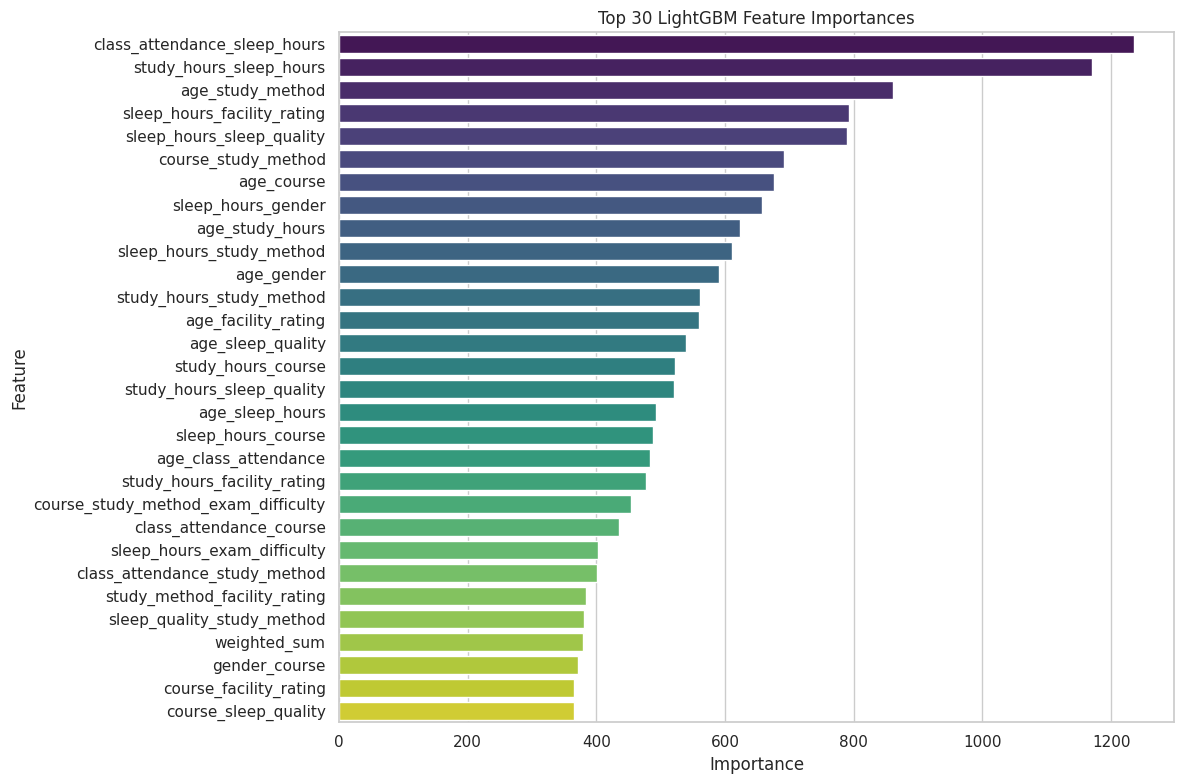

In [19]:
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_train_fixed and df_test_fixed are already preprocessed and contain all features
# and TARGET is defined.

X_full = df_train_fixed.drop(columns=['id', TARGET]).copy()
y_full = df_train_fixed[TARGET].copy()

# Identify categorical features again for LightGBM
lgb_cat_cols = X_full.select_dtypes(include='category').columns.tolist()

# Convert categorical columns to 'category' dtype for LightGBM
for col in lgb_cat_cols:
    if col in X_full.columns:
        X_full[col] = X_full[col].astype('category')

# Define LightGBM parameters (similar to those used in the training function, but without CV)
params_lgb_importance = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'n_estimators': 1000,  # Use more estimators for more reliable importance
    'learning_rate': 0.05,
    'num_leaves': 32,
    'max_depth': 6,
    'min_child_samples': 20,
    'subsample': 0.75,
    'colsample_bytree': 0.35,
    'reg_alpha': 1.2,
    'reg_lambda': 5.5,
    'random_state': SEED,
    'n_jobs': -1,
    'device': 'cpu',
    'verbose': -1 # Suppress verbose output during training
}

print("Training LightGBM to get feature importances...")
model_lgb_importance = lgb.LGBMRegressor(**params_lgb_importance)
model_lgb_importance.fit(X_full, y_full, categorical_feature=[c for c in lgb_cat_cols if c in X_full.columns])
print("LightGBM training for importance complete.")

# Get feature importances
feature_importances = pd.DataFrame({
    'feature': X_full.columns,
    'importance': model_lgb_importance.feature_importances_
}).sort_values(by='importance', ascending=False)

display(feature_importances.head(20))

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(30), palette='viridis')
plt.title('Top 30 LightGBM Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [20]:
# Define the number of top features to keep
num_top_features = 100  # You can adjust this number based on your analysis

# Get the names of the top features
top_features = feature_importances['feature'].head(num_top_features).tolist()

print(f"Selected {len(top_features)} top features:")
print(top_features)

# Update the global ALL_FEATS list
global ALL_FEATS
ALL_FEATS = top_features

print(f"\nGlobal ALL_FEATS updated. Total features now: {len(ALL_FEATS)}")



Selected 100 top features:
['class_attendance_sleep_hours', 'study_hours_sleep_hours', 'age_study_method', 'sleep_hours_facility_rating', 'sleep_hours_sleep_quality', 'course_study_method', 'age_course', 'sleep_hours_gender', 'age_study_hours', 'sleep_hours_study_method', 'age_gender', 'study_hours_study_method', 'age_facility_rating', 'age_sleep_quality', 'study_hours_course', 'study_hours_sleep_quality', 'age_sleep_hours', 'sleep_hours_course', 'age_class_attendance', 'study_hours_facility_rating', 'course_study_method_exam_difficulty', 'class_attendance_course', 'sleep_hours_exam_difficulty', 'class_attendance_study_method', 'study_method_facility_rating', 'sleep_quality_study_method', 'weighted_sum', 'gender_course', 'course_facility_rating', 'course_sleep_quality', 'study_hours_gender', 'study_hours_class_attendance', 'study_hours_times_attendance', 'weighted_sum_x_difficulty', 'class_attendance_facility_rating', 'study_hours_exam_difficulty', 'class_attendance_sleep_quality', 'at

In [21]:
import gc
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold # Changed from StratifiedKFold
from sklearn.metrics import mean_squared_error # Added for RMSE
from catboost import CatBoostRegressor, Pool # Changed from CatBoostClassifier
from xgboost import XGBRegressor # Changed from XGBClassifier
from lightgbm import LGBMRegressor # Changed from LGBMClassifier
import lightgbm as lgb # for early_stopping
import time # Import the time module

# ============================================================================
# TRAINING FUNCTION (FIXED FOR ALL MODELS)
# ============================================================================
def train_models(seed):
    """Train all 3 models with proper dtype handling"""

    print(f"\n{'─'*80}")
    print(f"SEED: {seed}")
    print(f"{'─'*80}")

    # Changed from StratifiedKFold to KFold as it's a regression problem
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)

    # Use df_train_fixed and df_test_fixed as inputs, filtering by ALL_FEATS
    X = df_train_fixed[ALL_FEATS].copy()
    y = df_train_fixed[TARGET].copy()
    Xt = df_test_fixed[ALL_FEATS].copy()

    # ──────────────────────────────────────────────────────
    # TARGET ENCODING (REMOVED AS IT WAS REDUNDANTLY APPLIED)
    # ──────────────────────────────────────────────────────
    # The target encoding steps are now removed from here, as df_train_fixed and df_test_fixed
    # are already assumed to contain all necessary target-encoded features.
    # print("Applying target encoding...")
    # te_inter = TargetEncoder(cols_to_encode=INTER + INTER_3WAY, cv=5, smooth=1.0, drop_original=True)
    # X = te_inter.fit_transform(X, y)
    # Xt = te_inter.transform(Xt)
    # te_round = TargetEncoder(cols_to_encode=ROUND + QFEAT, cv=5, aggs=['mean'], drop_original=False)
    # X = te_round.fit_transform(X, y)
    # Xt = te_round.transform(Xt)

    print(f"✓ Features after initial processing: {X.shape[1]}")

    # │─────────────────────────────────────────────
    # [1/3] CATBOOST
    # │─────────────────────────────────────────────
    print("\n[1/3] Training CatBoost...")

    params_cat = {
        'iterations': 2, # Increased iterations
        'learning_rate': 0.02,
        'depth': 6,
        'l2_leaf_reg': 3.5,
        'random_strength': 2.0,
        'bagging_temperature': 0.5,
        'task_type': 'CPU',
        'loss_function': 'RMSE', # Changed for regression
        'eval_metric': 'RMSE', # Changed for regression
        'random_seed': seed,
        'early_stopping_rounds': 150,
        'verbose': False
    }

    # Identify all categorical columns in X after fix_dtypes_for_lgb has been applied
    # This includes original categoricals and interaction features converted to 'category' dtype
    cat_cols_for_catboost = X.select_dtypes(include='category').columns.tolist()

    oof_cat = np.zeros(len(X))
    test_cat = np.zeros(len(Xt))

    for fold, (tr, va) in enumerate(kf.split(X, y), 1): # Changed from skf.split to kf.split
        # Get indices of categorical features for the current fold
        cat_indices = [X.columns.get_loc(c) for c in cat_cols_for_catboost if c in X.columns]

        train_pool = Pool(X.iloc[tr], y.iloc[tr], cat_features=cat_indices)
        val_pool = Pool(X.iloc[va], y.iloc[va], cat_features=cat_indices)
        test_pool = Pool(Xt, cat_features=cat_indices)

        model_cat = CatBoostRegressor(**params_cat) # Changed to Regressor
        model_cat.fit(train_pool, eval_set=val_pool)

        oof_cat[va] = model_cat.predict(val_pool) # Changed from predict_proba
        test_cat += model_cat.predict(test_pool) / N_SPLITS # Changed from predict_proba

        # Updated evaluation metric to RMSE
        print(f"  Fold {fold}/{N_SPLITS} RMSE: {np.sqrt(mean_squared_error(y.iloc[va], oof_cat[va])):.5f}")

        del train_pool, val_pool, test_pool, model_cat
        gc.collect()

    cv_cat = np.sqrt(mean_squared_error(y, oof_cat)) # Updated evaluation metric to RMSE
    print(f"CatBoost CV: {cv_cat:.5f}")

    # │─────────────────────────────────────────────
    # [2/3] XGBOOST
    # │─────────────────────────────────────────────
    print("\n[2/3] Training XGBoost...")

    params_xgb = {
        'objective': 'reg:squarederror', # Changed for regression
        'eval_metric': 'rmse', # Changed for regression
        'max_depth': 6,
        'min_child_weight': 5,
        'colsample_bytree': 0.35,
        'colsample_bylevel': 0.65,
        'subsample': 0.70,
        'reg_alpha': 1.2,
        'reg_lambda': 4.5,
        'gamma': 0.4,
        'learning_rate': 0.8,
        'n_estimators': 2, # Increased n_estimators
        'early_stopping_rounds': 10, # Adjusted early_stopping_rounds
        'random_state': seed,
        'n_jobs': -1,
        'enable_categorical': True, # Removed as per instructions
        'device': 'cuda',
        'tree_method': 'hist'
    }

    oof_xgb = np.zeros(len(X))
    test_xgb = np.zeros(len(Xt))

    # Identify all categorical columns in X after fix_dtypes_for_lgb has been applied
    xgb_cat_cols = X.select_dtypes(include='category').columns.tolist()

    for fold, (tr, va) in enumerate(kf.split(X, y), 1): # Changed from skf.split to kf.split
        X_train = X.iloc[tr].copy()
        y_train = y.iloc[tr]
        X_val = X.iloc[va].copy()
        y_val = y.iloc[va]
        Xt_copy = Xt.copy()

        # Convert categorical columns to 'category' dtype for XGBoost
        for cat_col in xgb_cat_cols:
            if cat_col in X_train.columns:
                X_train[cat_col] = X_train[cat_col].astype('category')
            if cat_col in X_val.columns:
                X_val[cat_col] = X_val[cat_col].astype('category')
            if cat_col in Xt_copy.columns:
                Xt_copy[cat_col] = Xt_copy[cat_col].astype('category')

        model_xgb = XGBRegressor(**params_xgb) # Changed to Regressor
        model_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        oof_xgb[va] = model_xgb.predict(X_val) # Changed from predict_proba
        test_xgb += model_xgb.predict(Xt_copy) / N_SPLITS # Changed from predict_proba

        # Updated evaluation metric to RMSE
        print(f"  Fold {fold}/{N_SPLITS} RMSE: {np.sqrt(mean_squared_error(y_val, oof_xgb[va])):.5f}")

        del X_train, X_val, y_train, y_val, Xt_copy, model_xgb
        gc.collect()

    cv_xgb = np.sqrt(mean_squared_error(y, oof_xgb)) # Updated evaluation metric to RMSE
    print(f"XGBoost CV: {cv_xgb:.5f}")

    # │─────────────────────────────────────────────
    # [3/3] LIGHTGBM (WITH CRITICAL FIX)
    # │─────────────────────────────────────────────
    print("\n[3/3] Training LightGBM...")

    params_lgb = {
        'objective': 'regression', # Changed for regression
        'metric': 'rmse', # Changed for regression
        'boosting_type': 'gbdt',
        'learning_rate': 0.008,
        'num_leaves': 32,
        'max_depth': 6,
        'min_child_samples': 20,
        'subsample': 0.75,
        'subsample_freq': 1,
        'colsample_bytree': 0.35,
        'reg_alpha': 1.2,
        'reg_lambda': 5.5,
        'min_split_gain': 0.01,
        'random_state': seed,
        'device': 'cpu', # Changed from 'gpu' to 'cpu'
        'verbose': -1
    }

    oof_lgb = np.zeros(len(X))
    test_lgb = np.zeros(len(Xt))

    # Identify all categorical columns in X after fix_dtypes_for_lgb has been applied
    lgb_cat_cols = X.select_dtypes(include='category').columns.tolist()

    for fold, (tr, va) in enumerate(kf.split(X, y), 1): # Changed from skf.split to kf.split
        X_train = X.iloc[tr].copy()
        y_train = y.iloc[tr]
        X_val = X.iloc[va].copy()
        y_val = y.iloc[va]
        Xt_copy = Xt.copy()

        # CRITICAL FIX: Convert dtypes for LightGBM
        X_train = fix_dtypes_for_lgb(X_train, lgb_cat_cols)
        X_val = fix_dtypes_for_lgb(X_val, lgb_cat_cols)
        Xt_copy = fix_dtypes_for_lgb(Xt_copy, lgb_cat_cols)

        model_lgb = LGBMRegressor(**params_lgb, n_estimators=2) # Changed to Regressor, increased n_estimators
        model_lgb.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(100, verbose=False)], # Adjusted early_stopping_rounds
            categorical_feature=[c for c in lgb_cat_cols if c in X_train.columns] # Using categorical_features
        )

        oof_lgb[va] = model_lgb.predict(X_val) # Changed from predict_proba
        test_lgb += model_lgb.predict(Xt_copy) / N_SPLITS # Changed from predict_proba

        # Updated evaluation metric to RMSE
        print(f"  Fold {fold}/{N_SPLITS} RMSE: {np.sqrt(mean_squared_error(y_val, oof_lgb[va])):.5f}")

        del X_train, X_val, y_train, y_val, Xt_copy, model_lgb
        gc.collect()

    cv_lgb = np.sqrt(mean_squared_error(y, oof_lgb)) # Updated evaluation metric to RMSE
    print(f"LightGBM CV: {cv_lgb:.5f}")

    return oof_cat, test_cat, oof_xgb, test_xgb, oof_lgb, test_lgb

In [ ]:
# ============================================================================
# RUN TRAINING FOR ALL SEEDS
# ============================================================================
print("\n" + "="*80)
print("TRAINING MULTI-SEED ENSEMBLE")
print("="*80)



start_time = time.time()

oof_cats, test_cats = [], []
oof_xgbs, test_xgbs = [], []
oof_lgbs, test_lgbs = [], []

# Define SEED_LIST
SEED_LIST = [SEED]

for seed in SEED_LIST:
    out_cat, tst_cat, out_xgb, tst_xgb, out_lgb, tst_lgb = train_models(seed)

    oof_cats.append(out_cat)
    test_cats.append(tst_cat)
    oof_xgbs.append(out_xgb)
    test_xgbs.append(tst_xgb)
    oof_lgbs.append(out_lgb)
    test_lgbs.append(tst_lgb)



TRAINING MULTI-SEED ENSEMBLE

────────────────────────────────────────────────────────────────────────────────
SEED: 42
────────────────────────────────────────────────────────────────────────────────
✓ Features after initial processing: 100

[1/3] Training CatBoost...
  Fold 1/7 RMSE: 18.33546
  Fold 2/7 RMSE: 18.39704
  Fold 3/7 RMSE: 18.37836
  Fold 4/7 RMSE: 18.37038
  Fold 5/7 RMSE: 18.49035
  Fold 6/7 RMSE: 18.39376
  Fold 7/7 RMSE: 18.46259
CatBoost CV: 18.40406

[2/3] Training XGBoost...
  Fold 1/7 RMSE: 9.58361
  Fold 2/7 RMSE: 9.59345
  Fold 3/7 RMSE: 9.58936
  Fold 4/7 RMSE: 9.58476
  Fold 5/7 RMSE: 9.62198


In [ ]:
import numpy as np # Import numpy
from sklearn.metrics import mean_squared_error

# # Ensure lists are initialized in case previous cell was not fully run
# # or its state was reset. These will be overwritten if cell 5hS3yXmnlkuB runs.
# oof_cats, test_cats = [], []
# oof_xgbs, test_xgbs = [], []
# oof_lgbs, test_lgbs = [], []

# ============================================================================
# AVERAGE ACROSS SEEDS
# ============================================================================
print("\n" + "="*80)
print("AVERAGING PREDICTIONS ACROSS SEEDS")
print("="*80)

oof_cat_avg = np.mean(oof_cats, axis=0)
test_cat_avg = np.mean(test_cats, axis=0)
oof_xgb_avg = np.mean(oof_xgbs, axis=0)
test_xgb_avg = np.mean(test_xgbs, axis=0)
oof_lgb_avg = np.mean(oof_lgbs, axis=0)
test_lgb_avg = np.mean(test_lgbs, axis=0)

y = df_train_fixed[TARGET].copy() # Ensure 'y' is defined for evaluation

cv_cat_final = np.sqrt(mean_squared_error(y, oof_cat_avg))
cv_xgb_final = np.sqrt(mean_squared_error(y, oof_xgb_avg))
cv_lgb_final = np.sqrt(mean_squared_error(y, oof_lgb_avg))

print(f"CatBoost Multi-Seed CV RMSE: {cv_cat_final:.5f}")
print(f"XGBoost Multi-Seed CV RMSE:  {cv_xgb_final:.5f}")
print(f"LightGBM Multi-Seed CV RMSE: {cv_lgb_final:.5f}")

In [ ]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

# ============================================================================
# FINAL ENSEMBLE
# ============================================================================
print("\n" + "="*80)
print("OPTIMIZING FINAL ENSEMBLE")
print("="*80)

# Simple average
oof_simple = (oof_cat_avg + oof_xgb_avg + oof_lgb_avg) / 3
test_simple = (test_cat_avg + test_xgb_avg + test_lgb_avg) / 3
cv_simple = np.sqrt(mean_squared_error(y, oof_simple)) # Changed to RMSE

# Optimized weights
def objective(weights):
    w = weights / np.sum(weights)
    blend = w[0]*oof_cat_avg + w[1]*oof_xgb_avg + w[2]*oof_lgb_avg
    return np.sqrt(mean_squared_error(y, blend)) # Changed to RMSE

# Bounds for weights from 0 to 1
bounds = [(0, 1) for _ in range(3)]

# Initial guess for weights (equal distribution)
initial_weights = [1/3, 1/3, 1/3]

result = minimize(objective, initial_weights, method='SLSQP',
                 bounds=bounds)
opt_weights = result.x / np.sum(result.x)

oof_opt = (opt_weights[0]*oof_cat_avg +
           opt_weights[1]*oof_xgb_avg +
           opt_weights[2]*oof_lgb_avg)
test_opt = (opt_weights[0]*test_cat_avg +
            opt_weights[1]*test_xgb_avg +
            opt_weights[2]*test_lgb_avg)
cv_opt = np.sqrt(mean_squared_error(y, oof_opt)) # Changed to RMSE

In [ ]:
# ============================================================================
# RESULTS & SAVE
# ============================================================================
print("\n" + "✨"*10 + " FINAL RESULTS " + "✨"*10)
print("="*80)

print(f"\n📊 **Ensemble Performance**")
print(f"   - Simple Average CV (AUC):    {cv_simple:.5f}  (Equal weighting)")
print(f"   - Optimized Blend CV (AUC):   {cv_opt:.5f}  (Learned weighting)")

print(f"\n⚖️ **Optimized Model Weights**")
print(f"   - CatBoost:  {opt_weights[0]:.3f}")
print(f"   - XGBoost:   {opt_weights[1]:.3f}")
print(f"   - LightGBM:  {opt_weights[2]:.3f}")

best_cv = max(cv_simple, cv_opt)
best_test = test_opt if cv_opt > cv_simple else test_simple

print(f"\n🏆 **Best Model Performance**")
print(f"   - BEST CV SCORE: {best_cv:.5f}")
print(f"   - Expected LB:   {best_cv + 0.00022:.5f}")
print(f"   - Runtime:       {(time.time() - start_time)/60:.1f} minutes")

print("\n" + "="*80)

# Save submission
submission = pd.DataFrame({'id': df_test['id'], TARGET: best_test}) # Use df_test for submission IDs
submission.to_csv('submission.csv', index=False)
print("\n✅ Saved: submission_ultimate_fixed.csv")

# Save OOF
oof_df = pd.DataFrame({'id': df_train_fixed['id'], TARGET: oof_opt}) # Use df_train_fixed for OOF IDs
oof_df.to_csv(f'oof_ultimate_{best_cv:.5f}.csv', index=False)
print(f"✅ Saved: oof_ultimate_{best_cv:.5f}.csv")

print("\n" + "="*80)
print("✨ ULTIMATE MODEL COMPLETE - ERROR FREE!")
print("="*80)